In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-10-20 18:33:32.519103: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 18:33:32.521852: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 18:33:32.566324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-20 18:33:32.566360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-20 18:33:32.566391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
rd_state = 666

In [14]:
from sklearn.model_selection import train_test_split

all_data = pd.read_csv("train.csv")
challenge_input = pd.read_csv("test.csv")
challenge_input = challenge_input.drop('label', axis=1)

# Normalize pixel values in [0,1]
all_data.loc[:, all_data.columns != 'label'] = all_data.loc[:, all_data.columns != 'label']/255
challenge_input = challenge_input/255

all_input = all_data.drop('label', axis=1)
all_labels = all_data['label'].copy()

# Extract a validation set
train_input, validate_input, train_labels, validate_labels = train_test_split(all_input, all_labels, test_size=0.05, random_state=rd_state)

# Extract a testing set
train_input, test_input, train_labels, test_labels = train_test_split(train_input, train_labels, test_size=0.10, random_state=rd_state)

train_both = train_input.copy()
train_both['label'] = train_labels

# Sanity check
print("All data:  %s" % (all_data.shape,))
print("All input: %s" % (all_input.shape,))
print("Training:  %s" % (train_input.shape,))
print("Test set:  %s" % (test_input.shape,))
print("Validate:  %s" % (validate_input.shape,))
print("Challenge: %s" % (challenge_input.shape,))

All data:  (60000, 785)
All input: (60000, 784)
Training:  (51300, 784)
Test set:  (5700, 784)
Validate:  (3000, 784)
Challenge: (10000, 784)


In [5]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def label_str(label):
    return labels[label]

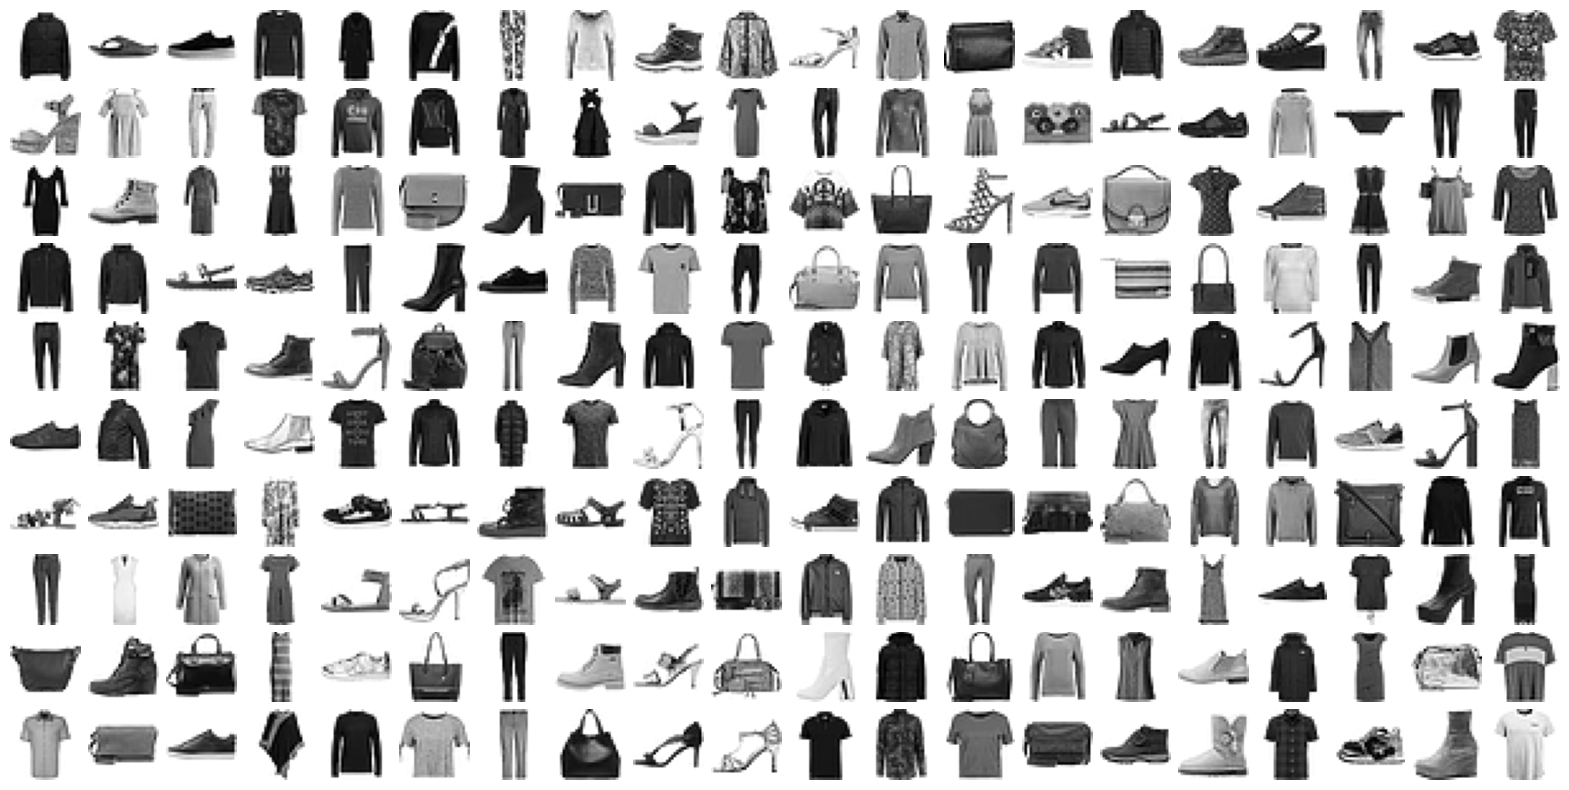

In [6]:
def show_digits(inp, X, Y):
    fX = 20
    fY = int(fX*Y/X)

    figure, axis = plt.subplots(max(Y, 2), max(X, 2), figsize=(fX,fY))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    for x in range(X):
        for y in range(Y):
            axis[y, x].imshow(inp.iloc[y*X+x].to_numpy().reshape(28, 28), cmap='gray_r')
            axis[y, x].axis('off')

# Let's peek at some random digits
show_digits(train_input, 20, 10)

In [8]:
# One-hot-encoding of labels
all_labels_ohe = pd.get_dummies(data=all_labels, columns=["label"]) * 1.0

In [28]:
# Let's build an autoencoder

# Whether to have a "semantic" autoencoder (where part of the latent layer corresponds to the labels)
# or a normal one
semantic = True

# Both input & output
n_input = 28*28
# Encoder structure
n_encoder = 200
# Encoding
n_trained_latent = 10
n_free_latent = 10
n_latent = n_trained_latent + n_free_latent
# Decoder structure
n_decoder = 200


if semantic:
  inputs = tf.keras.Input(shape=(n_input,))
  encoder = tf.keras.layers.Dense(n_encoder, activation="relu")(inputs)
  trained_latent = tf.keras.layers.Dense(n_trained_latent, activation="relu")(encoder)
  free_latent = tf.keras.layers.Dense(n_free_latent, activation="relu")(encoder)
  latent = tf.keras.layers.concatenate([trained_latent, free_latent])
  decoder = tf.keras.layers.Dense(n_decoder, activation="relu")(latent)
  outputs = tf.keras.layers.Dense(n_input)(decoder)

  enc_dec_train = tf.keras.Model(inputs=inputs, outputs=[outputs, trained_latent])

  enc_dec_train.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

  enc_dec_train.fit(all_input, [all_input, all_labels_ohe], epochs=100)

  enc_dec = tf.keras.Model(inputs=inputs, outputs=outputs)
  enc_dec.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
else:
  inputs = tf.keras.Input(shape=(n_input,))
  encoder = tf.keras.layers.Dense(n_encoder, activation="relu")(inputs)
  latent = tf.keras.layers.Dense(n_latent, activation="relu")(encoder)
  decoder = tf.keras.layers.Dense(n_decoder, activation="relu")(latent)
  outputs = tf.keras.layers.Dense(n_input)(decoder)

  enc_dec = tf.keras.Model(inputs=inputs, outputs=outputs)

  enc_dec.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

  enc_dec.fit(all_input, all_input, epochs=100)

print(enc_dec.summary())

Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247
Epoch 8/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241
Epoch 9/100
1875/1875 [==============================] -

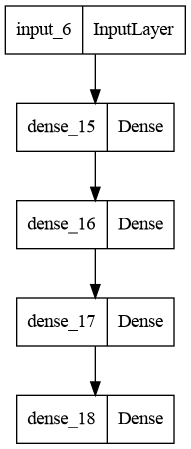

In [29]:
tf.keras.utils.plot_model(enc_dec)

313/313 [==============================] - 0s 869us/step


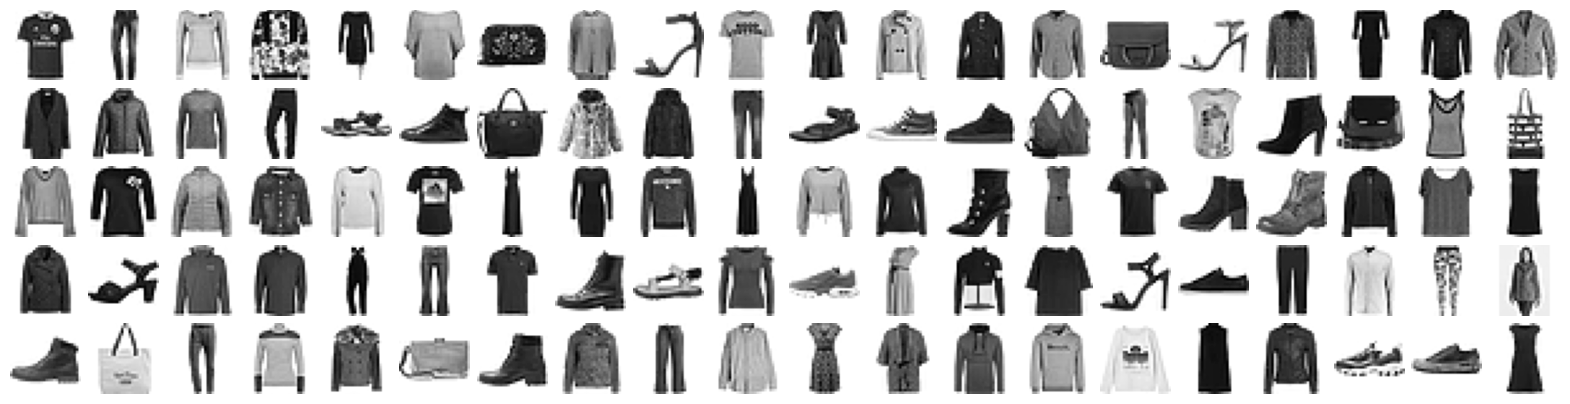

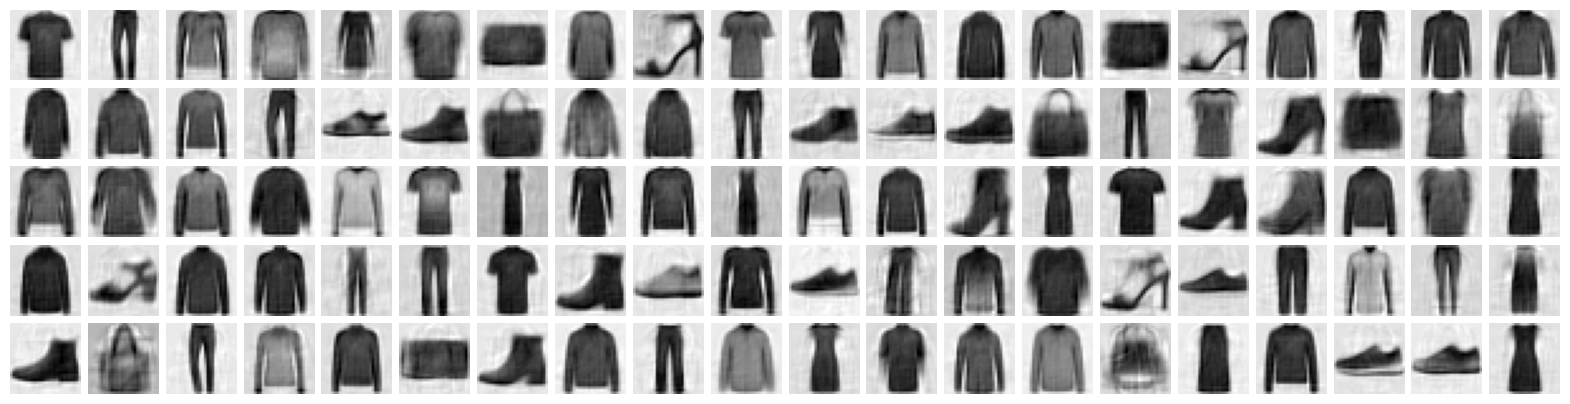

In [30]:
show_digits(challenge_input, 20, 5)
challenge_decoded = enc_dec.predict(challenge_input)
show_digits(pd.DataFrame(challenge_decoded), 20, 5)

In [16]:
# Extract the encoder and decoder
""" # This is the sequential version
encoder = tf.keras.Sequential()
decoder = tf.keras.Sequential()

for layer in enc_dec.layers[:2]:
  encoder.add(layer)

for layer in enc_dec.layers[2:]:
  decoder.add(layer)

# Print summary:
encoder.build((1, n_input))
decoder.build((1, n_latent))
print(encoder.summary())
print(decoder.summary())
"""

# This is the functional version
encoder = tf.keras.Model(inputs=inputs, outputs=latent)
decoder = tf.keras.Model(inputs=latent, outputs=outputs)

313/313 [==============================] - 0s 636us/step


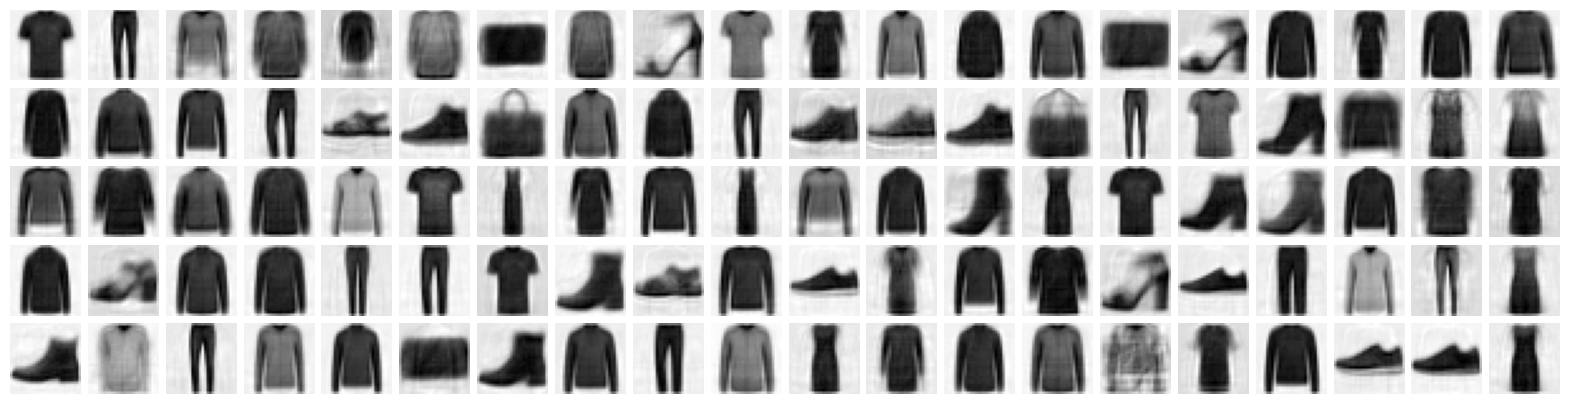

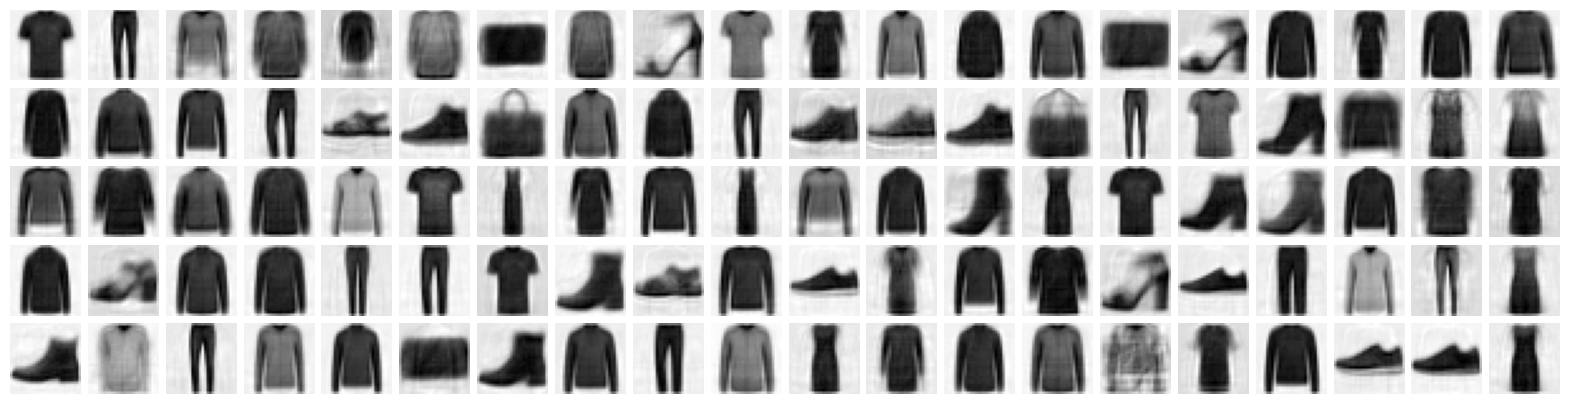

In [17]:
show_digits(pd.DataFrame(challenge_decoded), 20, 5)

challenge_decoded2 = decoder.predict(encoder.predict(challenge_input))
show_digits(pd.DataFrame(challenge_decoded2), 20, 5)

1604/1604 [==============================] - 1s 668us/step


'0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.] (+/- [0.24871939 0.0135345  0.         0.         0.         0.\n 0.         0.02697179 0.         0.         0.37990424 0.46537012])'

'1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] (+/- [0.02194999 0.16395481 0.         0.         0.         0.\n 0.         0.02454158 0.         0.         0.23426867 0.27806869])'

'2 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.] (+/- [5.35303019e-02 5.93748176e-03 0.00000000e+00 0.00000000e+00\n 0.00000000e+00 2.58325308e-04 0.00000000e+00 3.48340236e-02\n 0.00000000e+00 0.00000000e+00 4.70026016e-01 5.19984186e-01])'

'3 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.] (+/- [0.07389318 0.01611941 0.         0.         0.         0.\n 0.         0.02631312 0.         0.         0.28163558 0.40257165])'

'4 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.] (+/- [0.03086592 0.01273862 0.         0.         0.         0.\n 0.         0.03435637 0.         0.         0.49453431 0.42038774])'

'5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.] (+/- [0.0200269  0.00049358 0.         0.         0.         0.10821016\n 0.         0.04309414 0.         0.         0.49307472 0.29775369])'

'6 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.] (+/- [0.1667289  0.00377632 0.         0.         0.         0.00227557\n 0.         0.02603379 0.         0.         0.52973568 0.51389551])'

'7 -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] (+/- [0.00771614 0.         0.         0.         0.         0.04548653\n 0.         0.15331618 0.         0.         0.36820075 0.20870534])'

'8 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2.] (+/- [0.03665914 0.00615338 0.         0.         0.         0.01077869\n 0.         0.05247529 0.         0.         0.60185933 0.32958886])'

'9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1.] (+/- [0.04492043 0.00523146 0.         0.         0.         0.01883673\n 0.         0.08782713 0.         0.         0.40033221 0.280579  ])'

'Encoded values between 0.0 and 3.3210294'

'std between 0.0 and 0.6018593311309814'

1/1 [==============================] - 0s 13ms/step


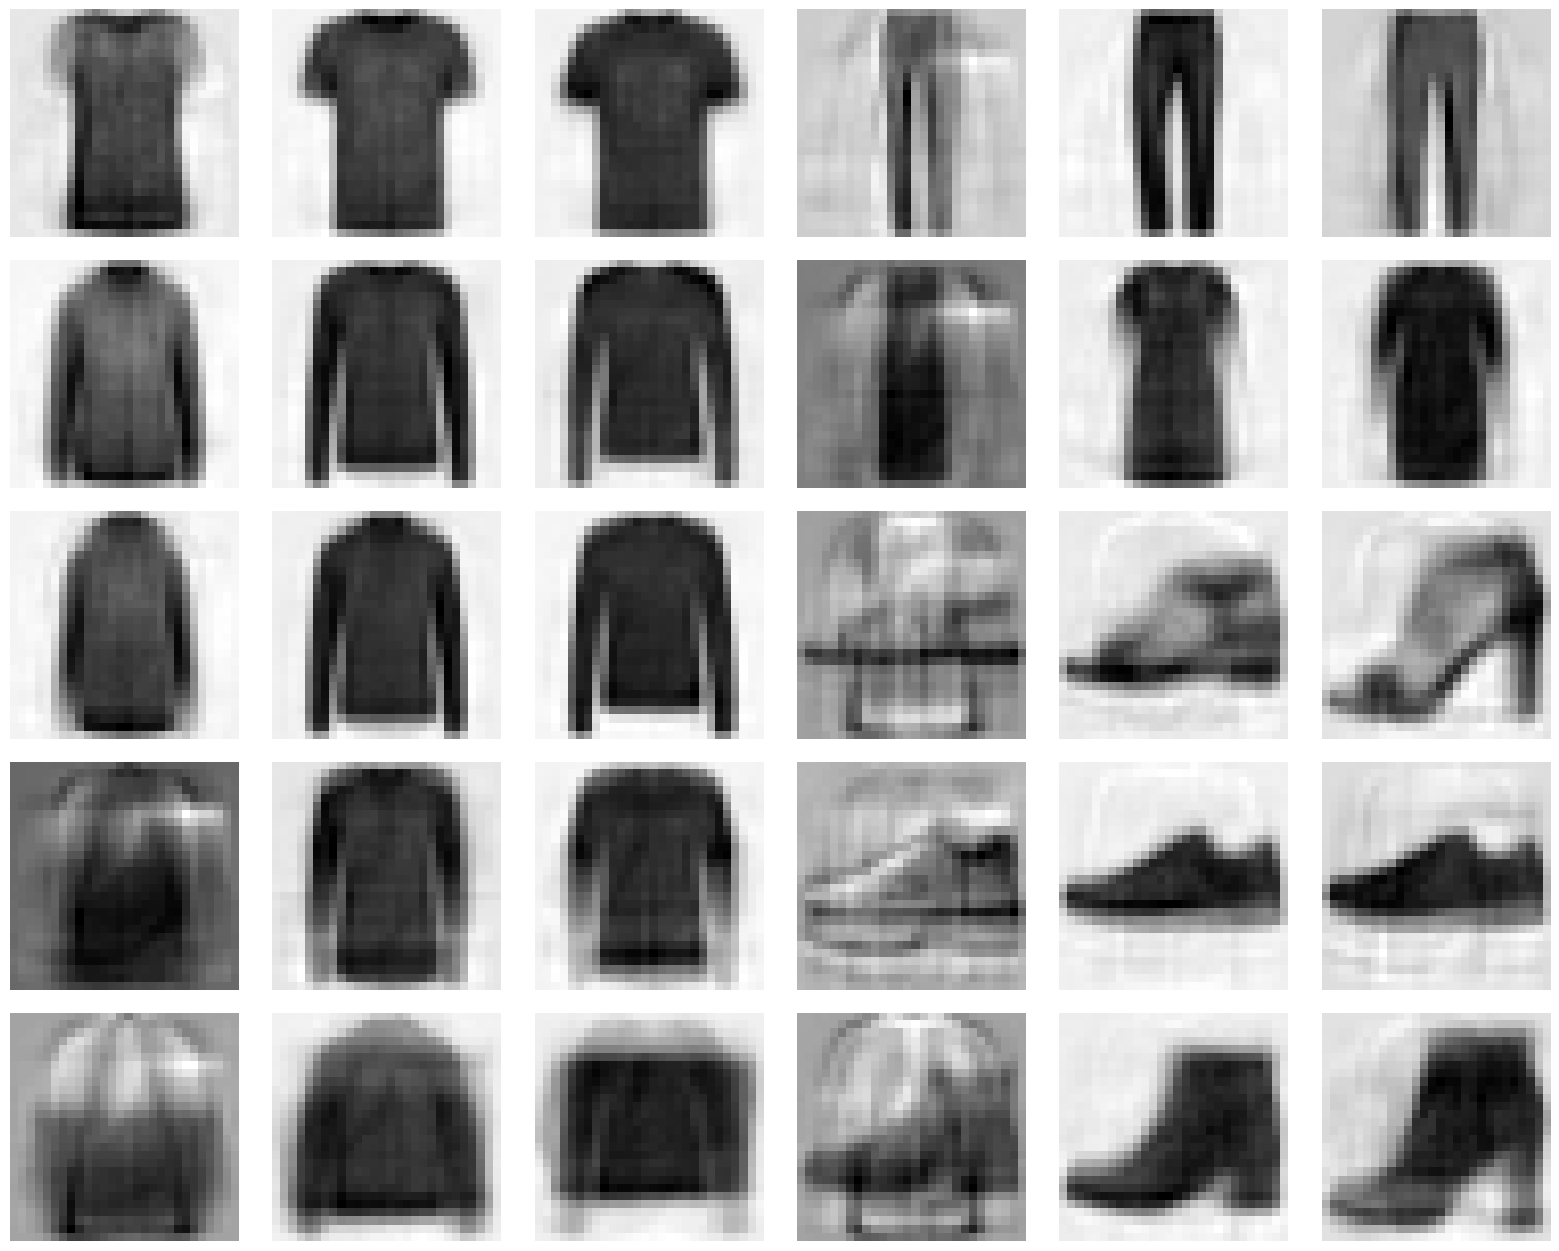

In [18]:
train_encoded = encoder.predict(train_input)

means = []
stds = []
for i in range(10):
    mean = pd.DataFrame(train_encoded[train_both['label'] == i]).describe().loc['mean'].to_numpy()
    std = pd.DataFrame(train_encoded[train_both['label'] == i]).describe().loc['std'].to_numpy()
    display("%s -> %s (+/- %s)" % (i, mean.round(), std))
    stds.extend(std)
    means.append(mean-std)
    means.append(mean)
    means.append(mean+std)

means = np.asarray(means)

display("Encoded values between %s and %s" % (min(train_encoded.flatten()), max(train_encoded.flatten())))
display("std between %s and %s" % (min(stds), max(stds)))

decoded_means = decoder.predict(means)
show_digits(pd.DataFrame(decoded_means), 6, 5)

4/4 [==============================] - 0s 1ms/step


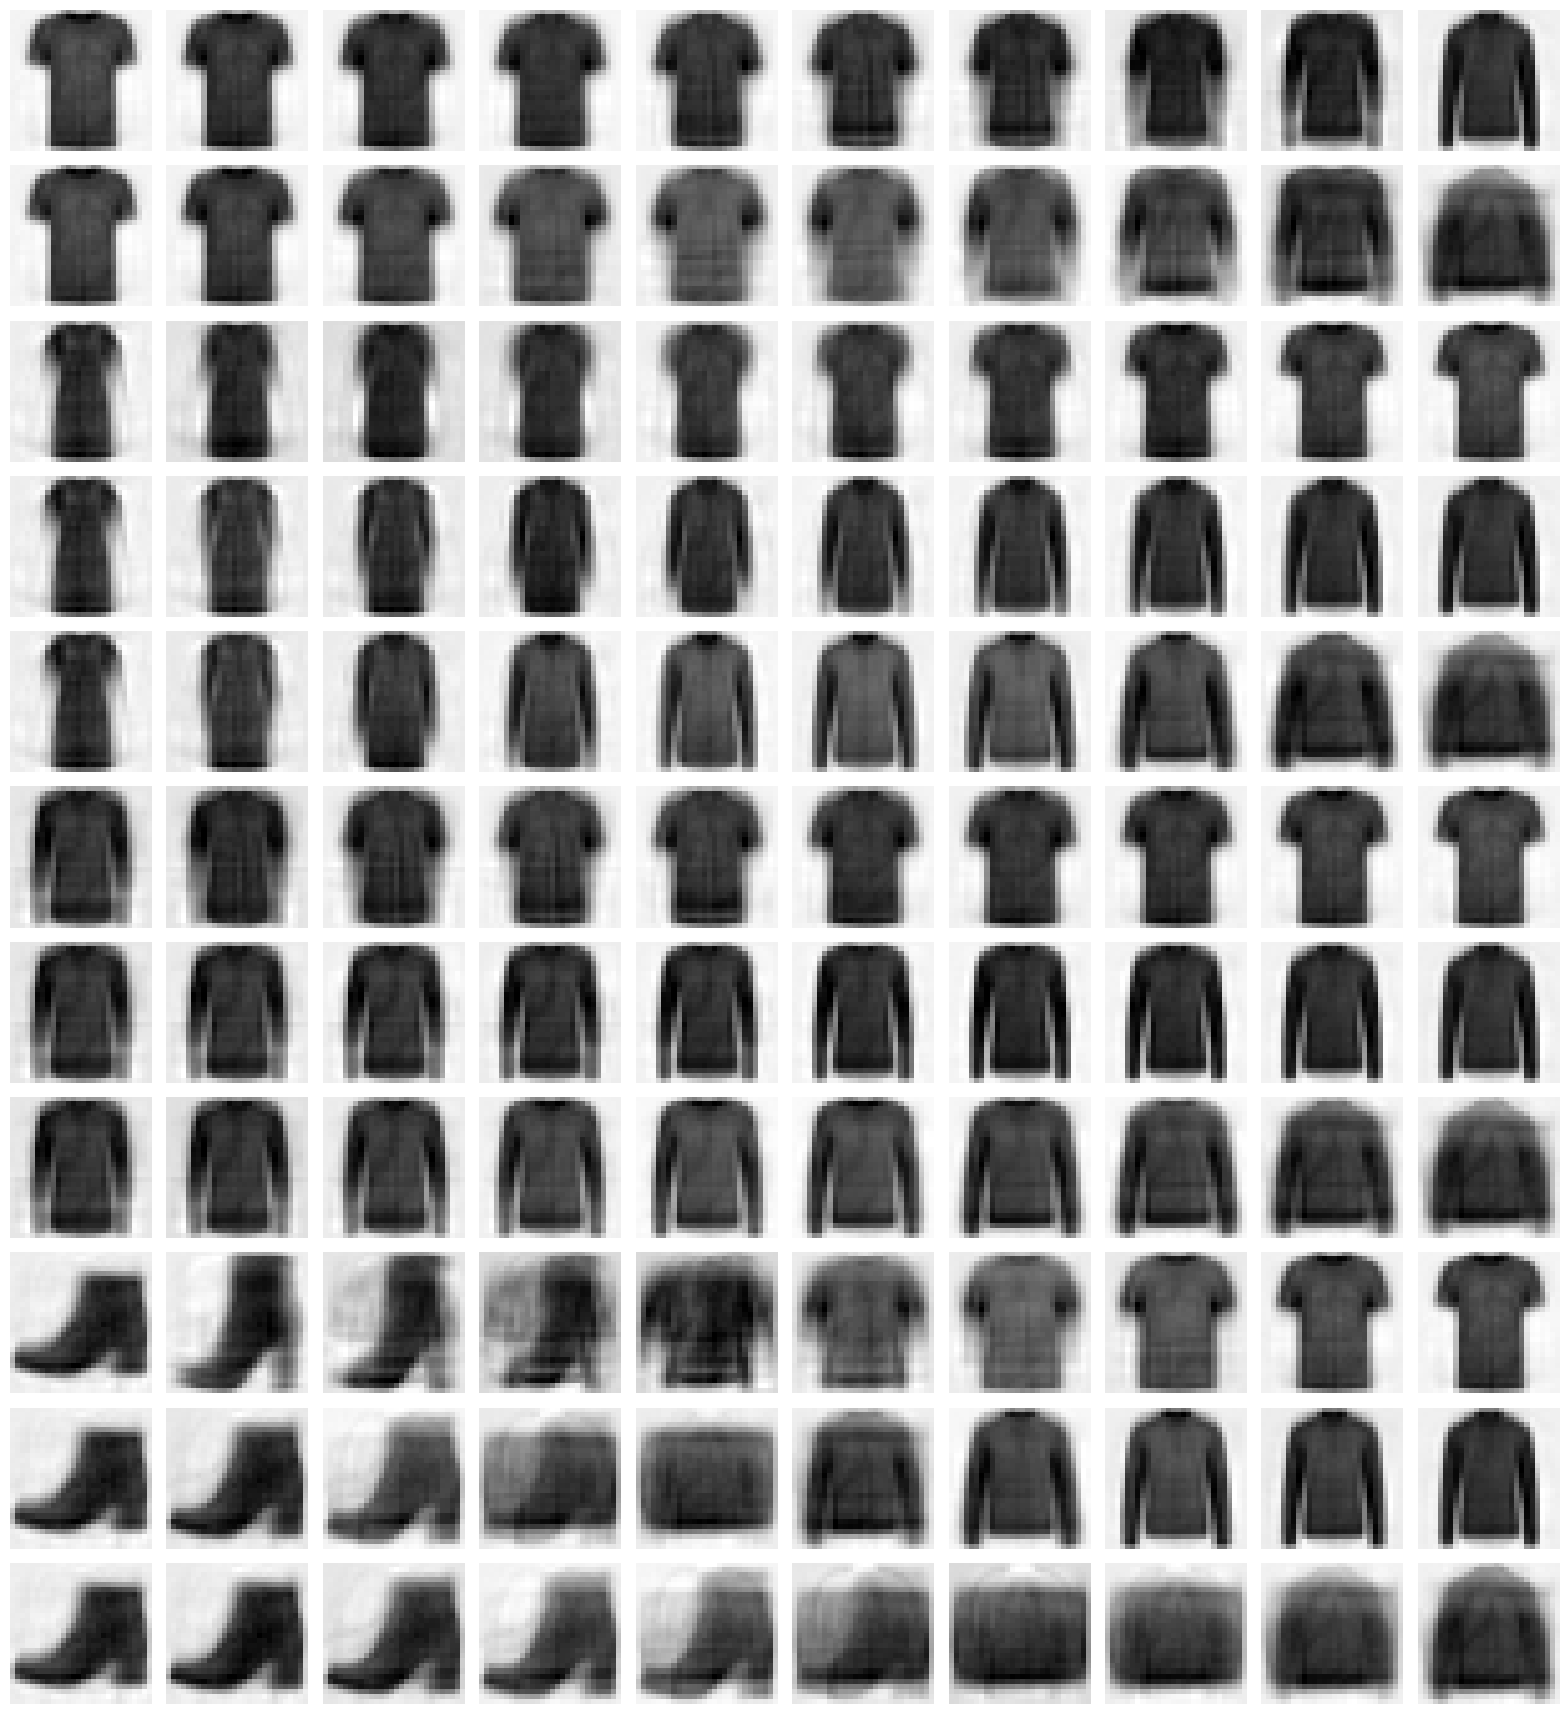

In [19]:
# Morphing one digit into another

steps = 10

def morph(fr, to, steps):
    d = [(x-y)/(steps-1) for (x,y) in zip(to, fr)]
    res = []
    for i in range(steps):
        res.append([x+i*y for (x,y) in zip(fr,d)])
    return res

enc = []
for i in range(10):
    enc.append(means[3*i+1])
    
myencoded = \
  morph(enc[0], enc[6], steps) + \
  morph(enc[0], enc[5], steps) + \
  morph(enc[1], enc[7], steps) + \
  morph(enc[1], enc[8], steps)

myencoded = []
for i in range(0, 10, 3):
    for j in range(0, 10, 4):
        if i == j:
            continue
        myencoded.extend(morph(enc[i], enc[j], steps))

decoded_myencoded = decoder.predict(myencoded)
show_digits(pd.DataFrame(decoded_myencoded), steps, len(myencoded)//steps)

1/1 [==============================] - 0s 15ms/step


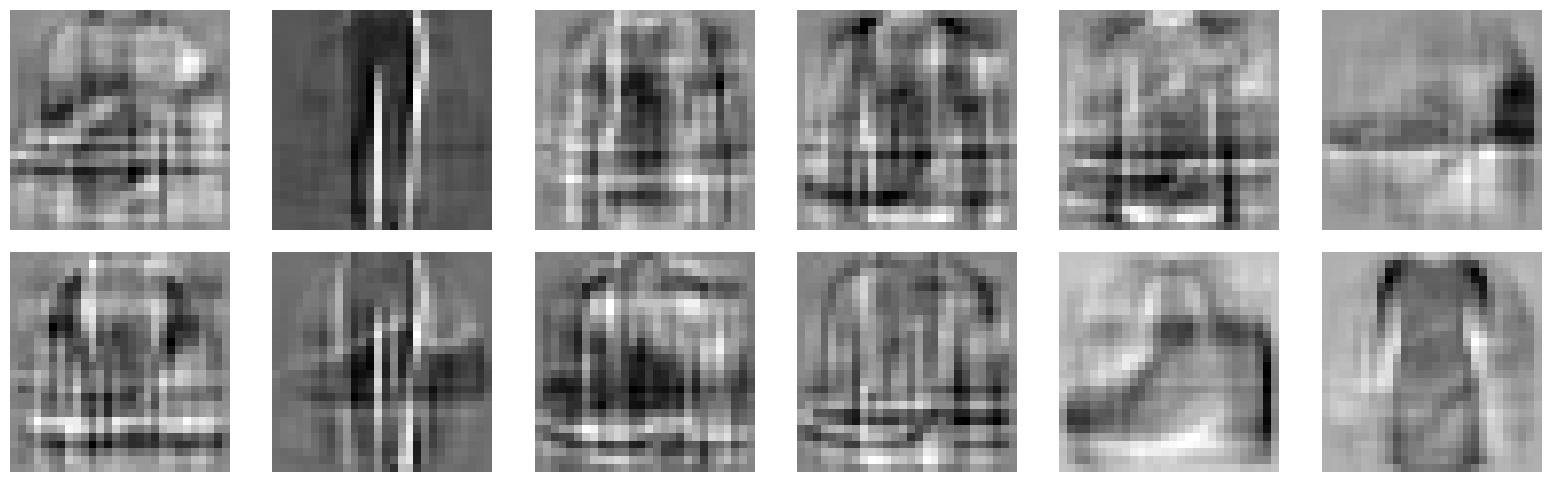

In [20]:
basis = decoder.predict(10*np.identity(n_latent))
show_digits(pd.DataFrame(basis), 6, 2)

In [21]:
def combis(n, vals):
    result = []
    if n == 1:
        return [[x] for x in vals]
    for l in combis(n-1, vals):
        for v in vals:
            result.append(l + [v])
    return result

2/2 [==============================] - 0s 1ms/step


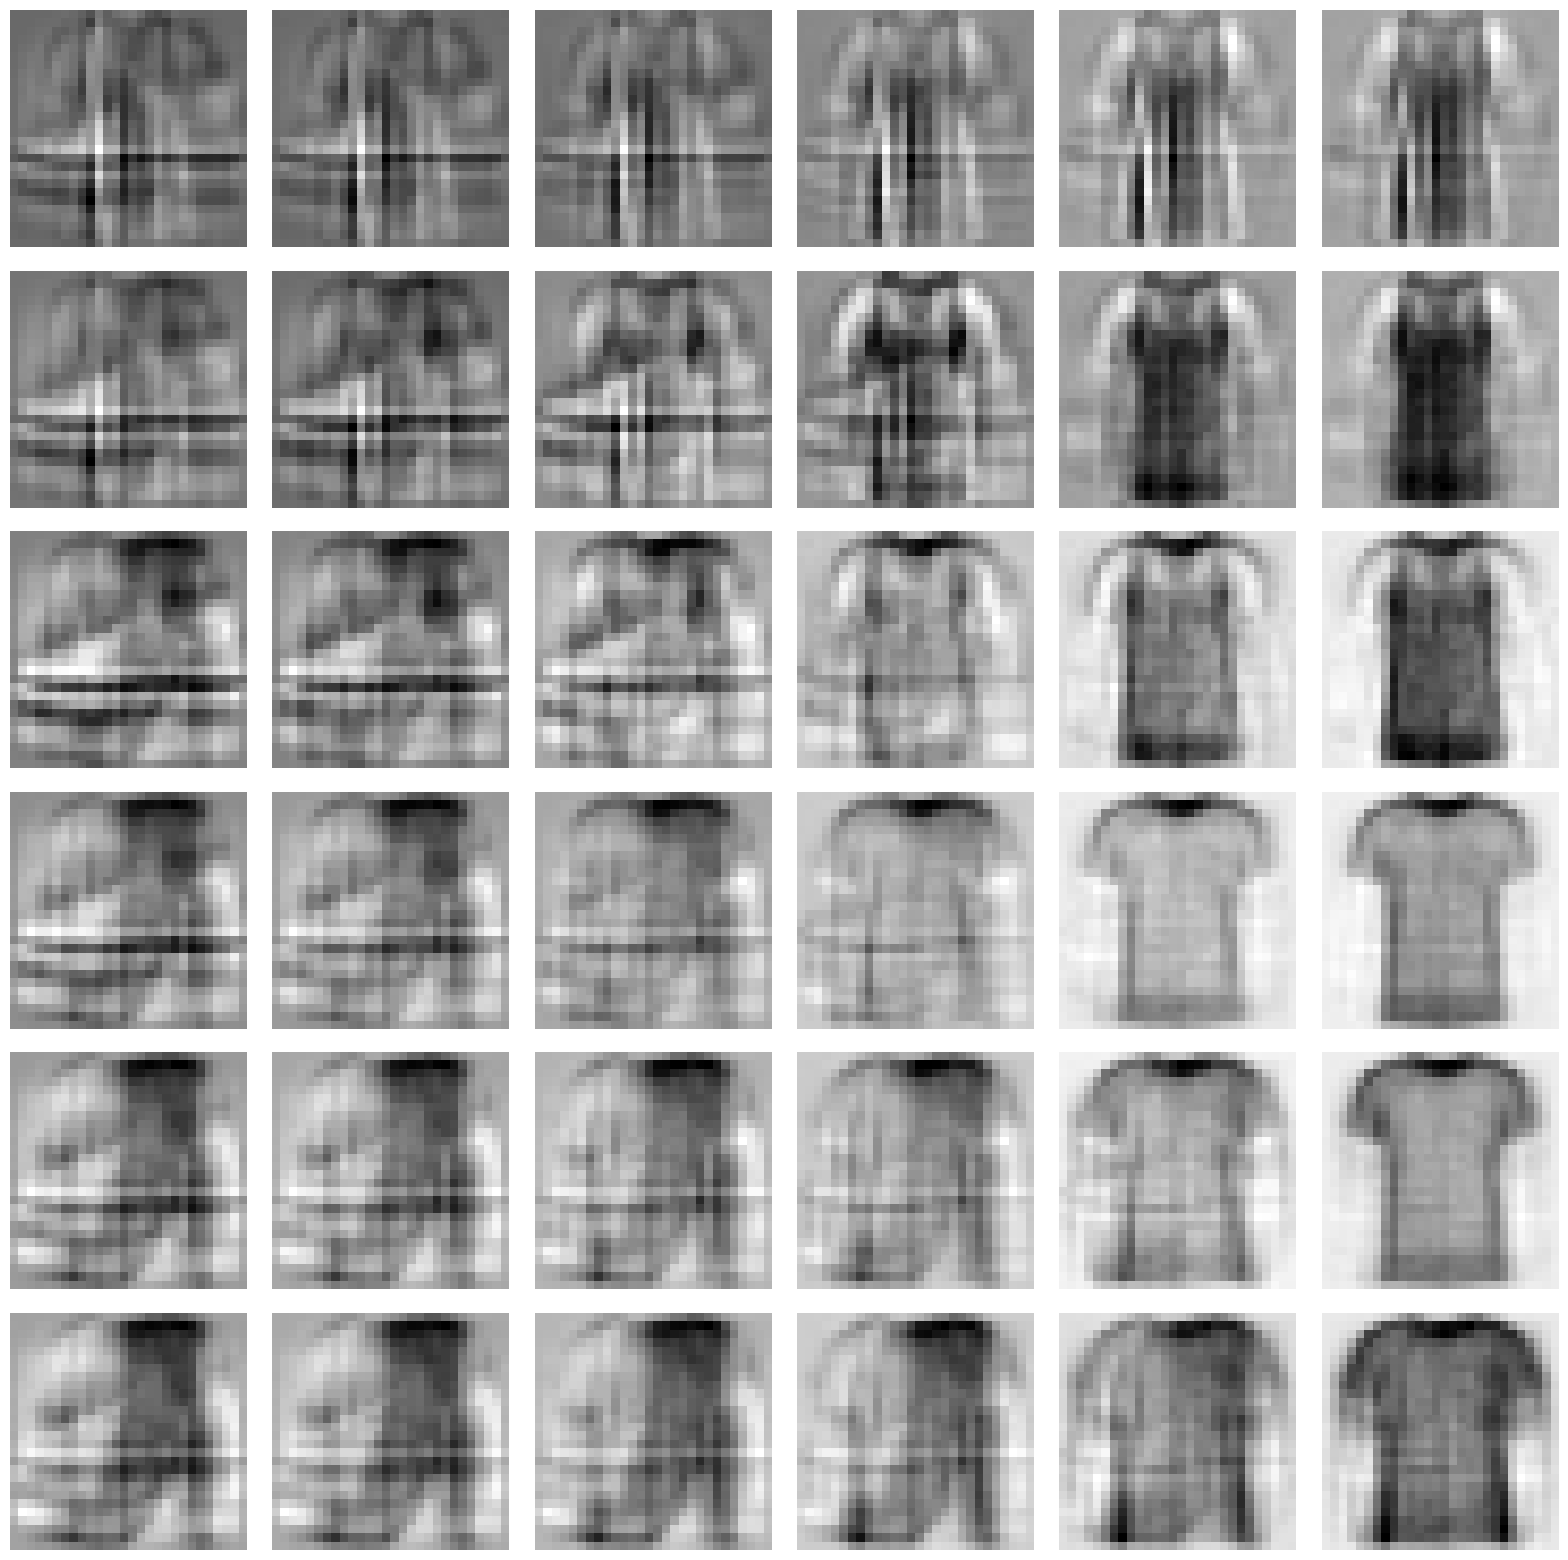

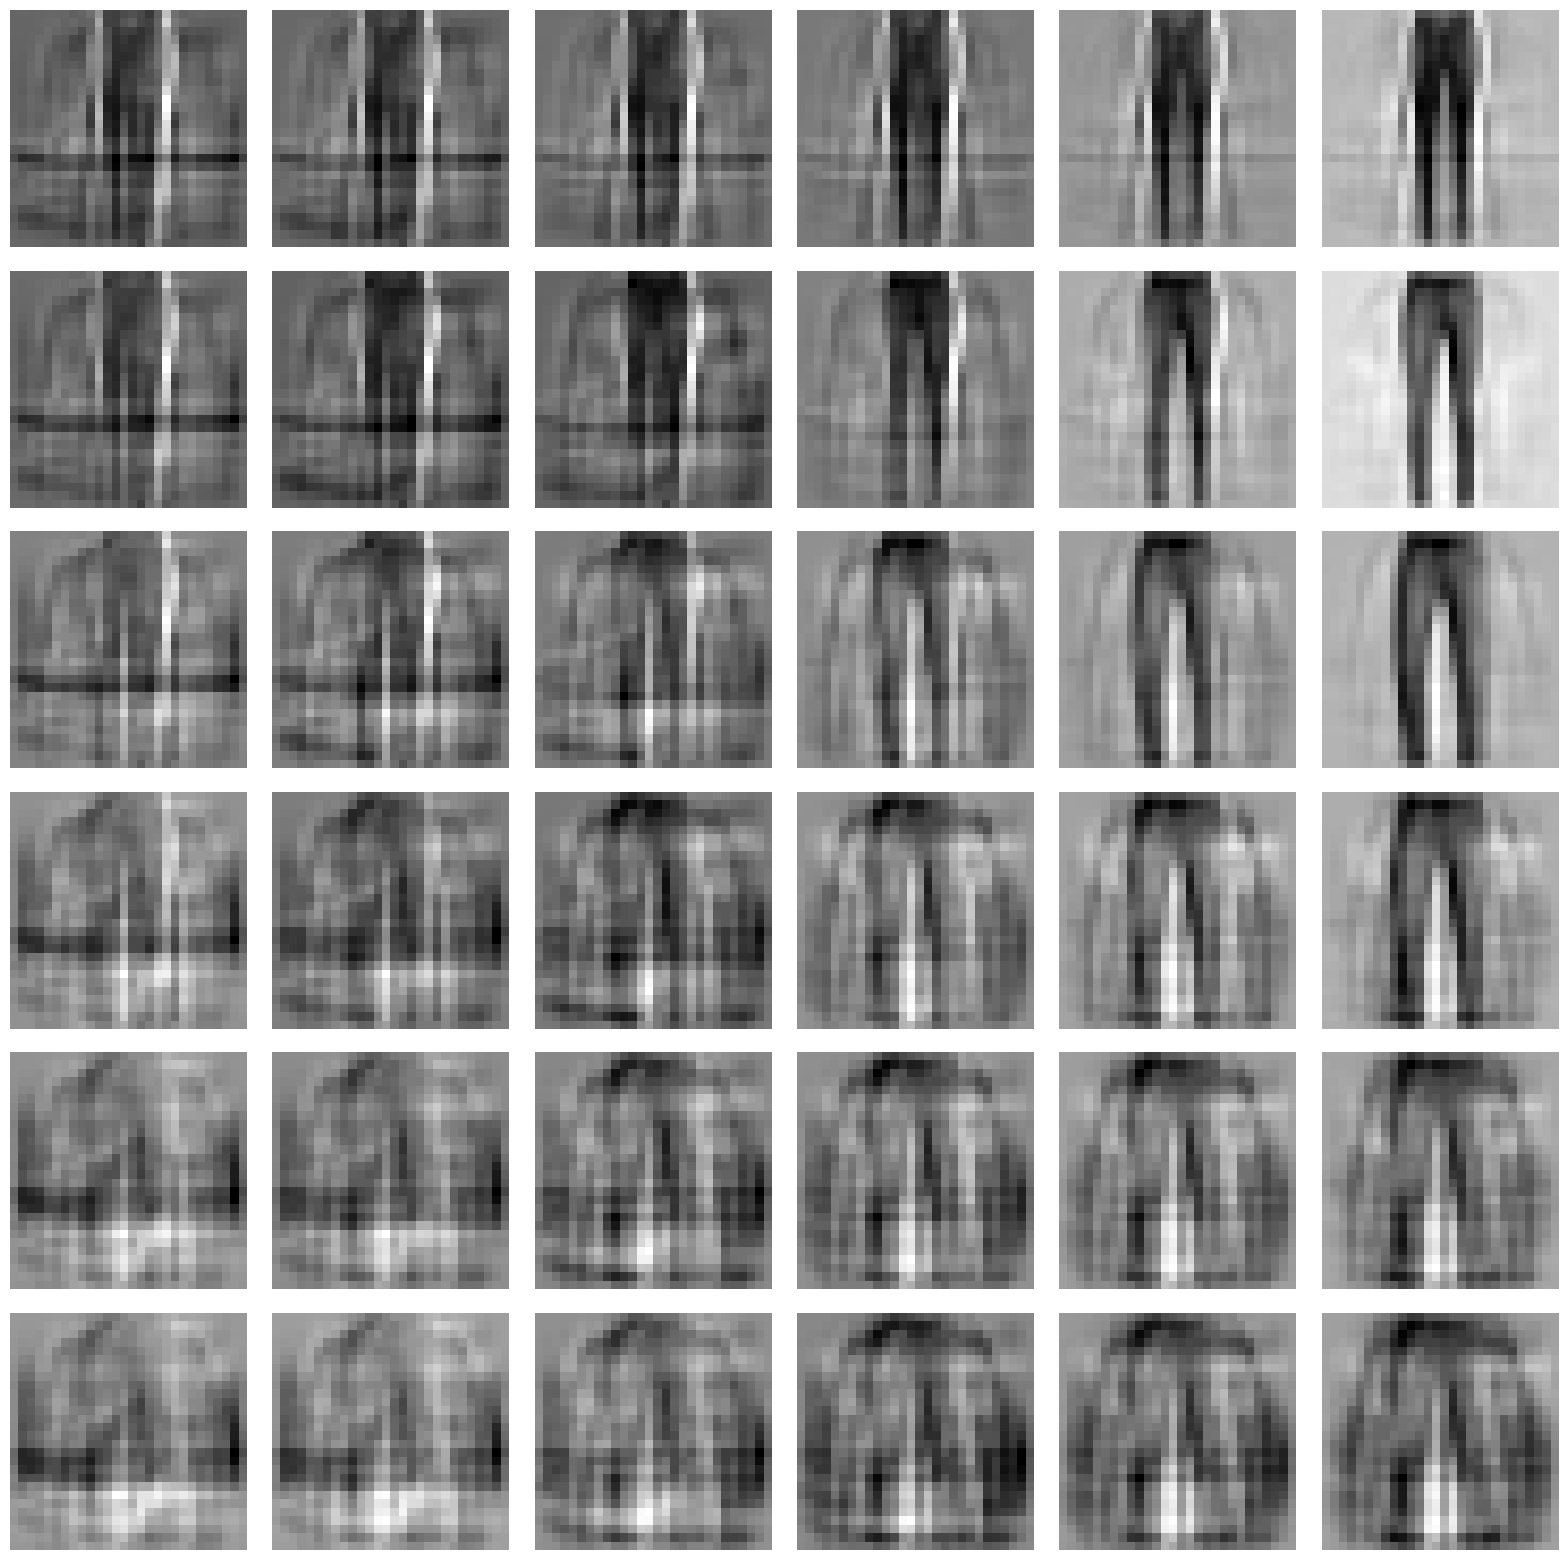

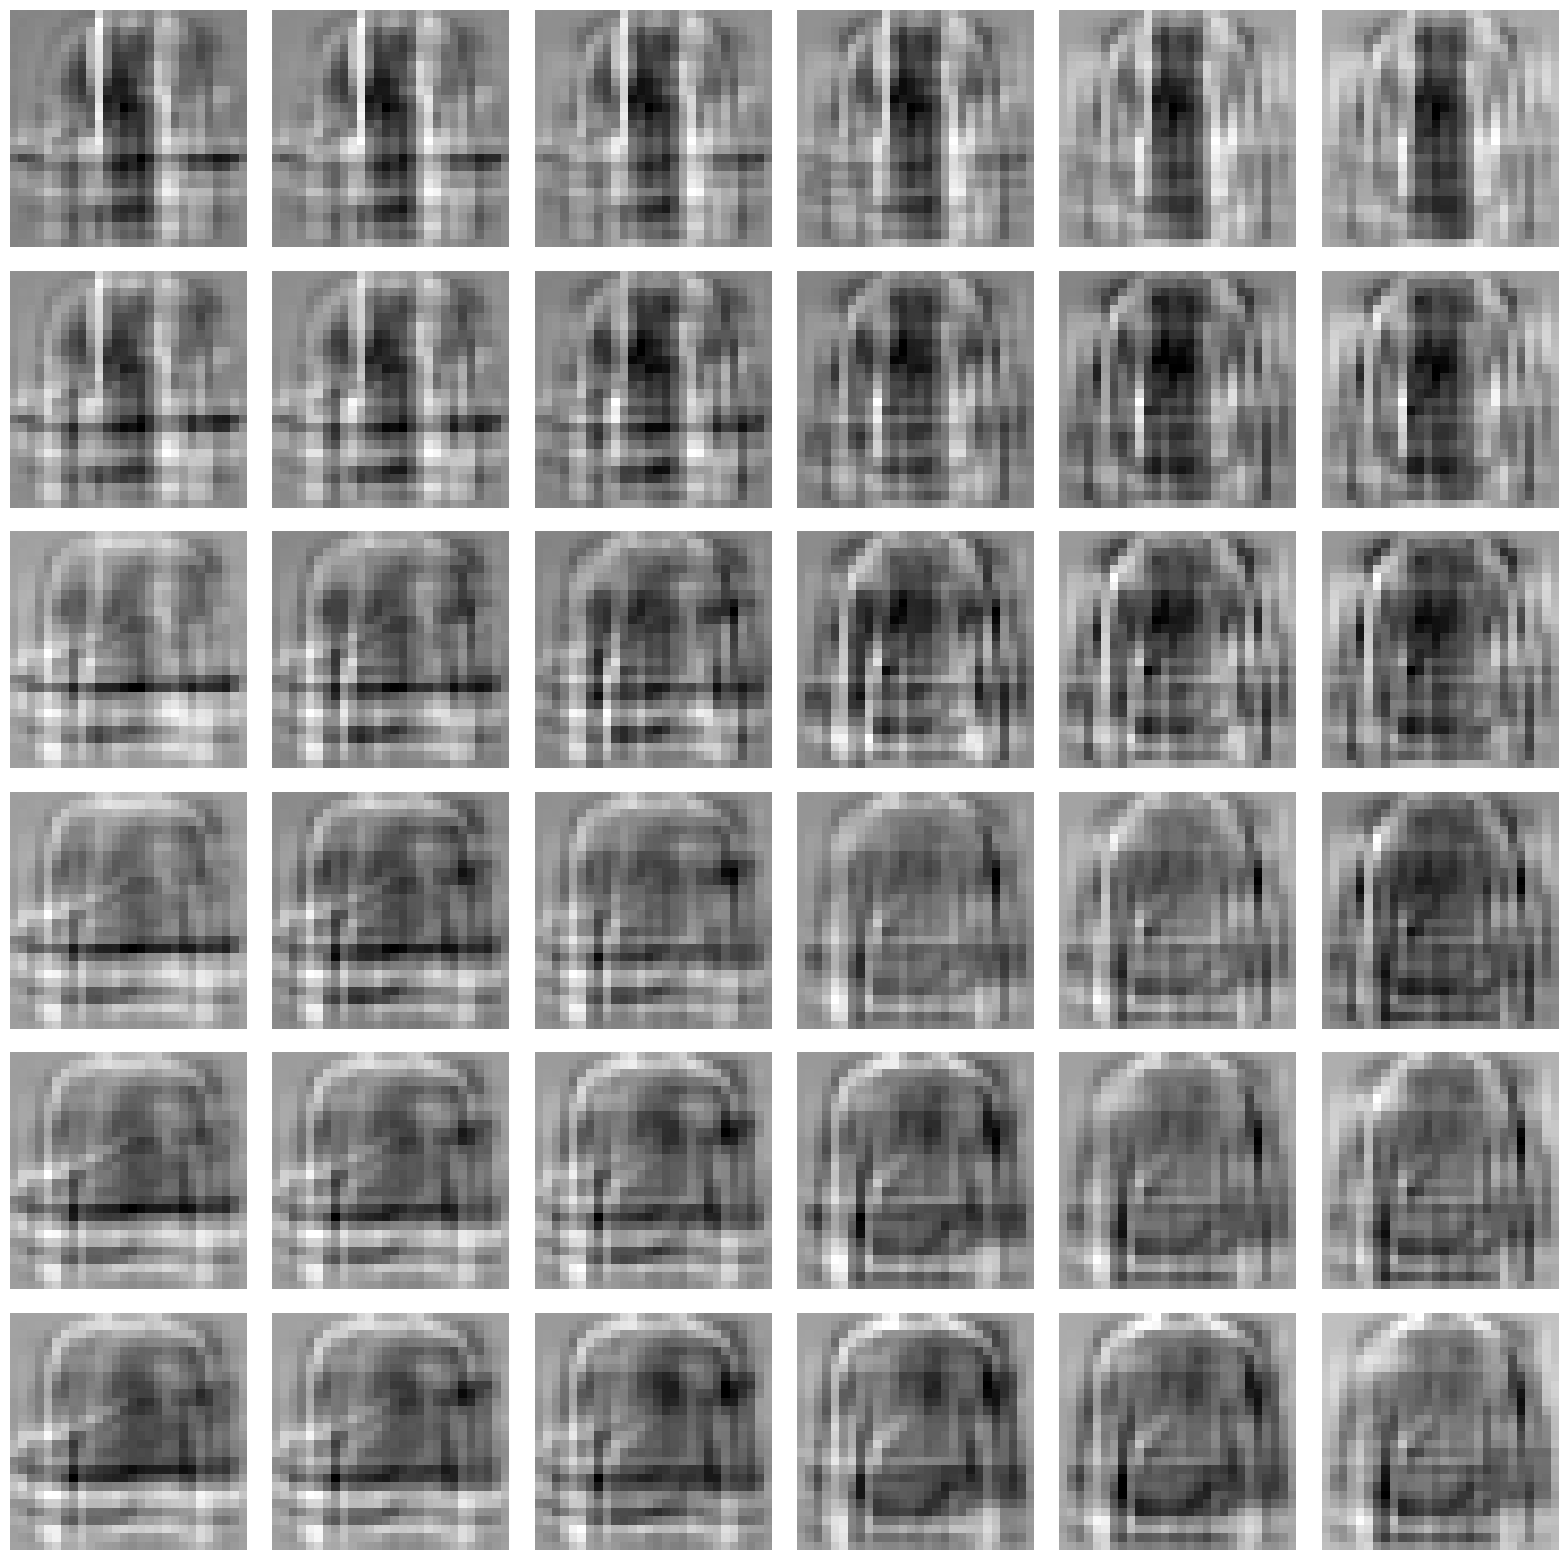

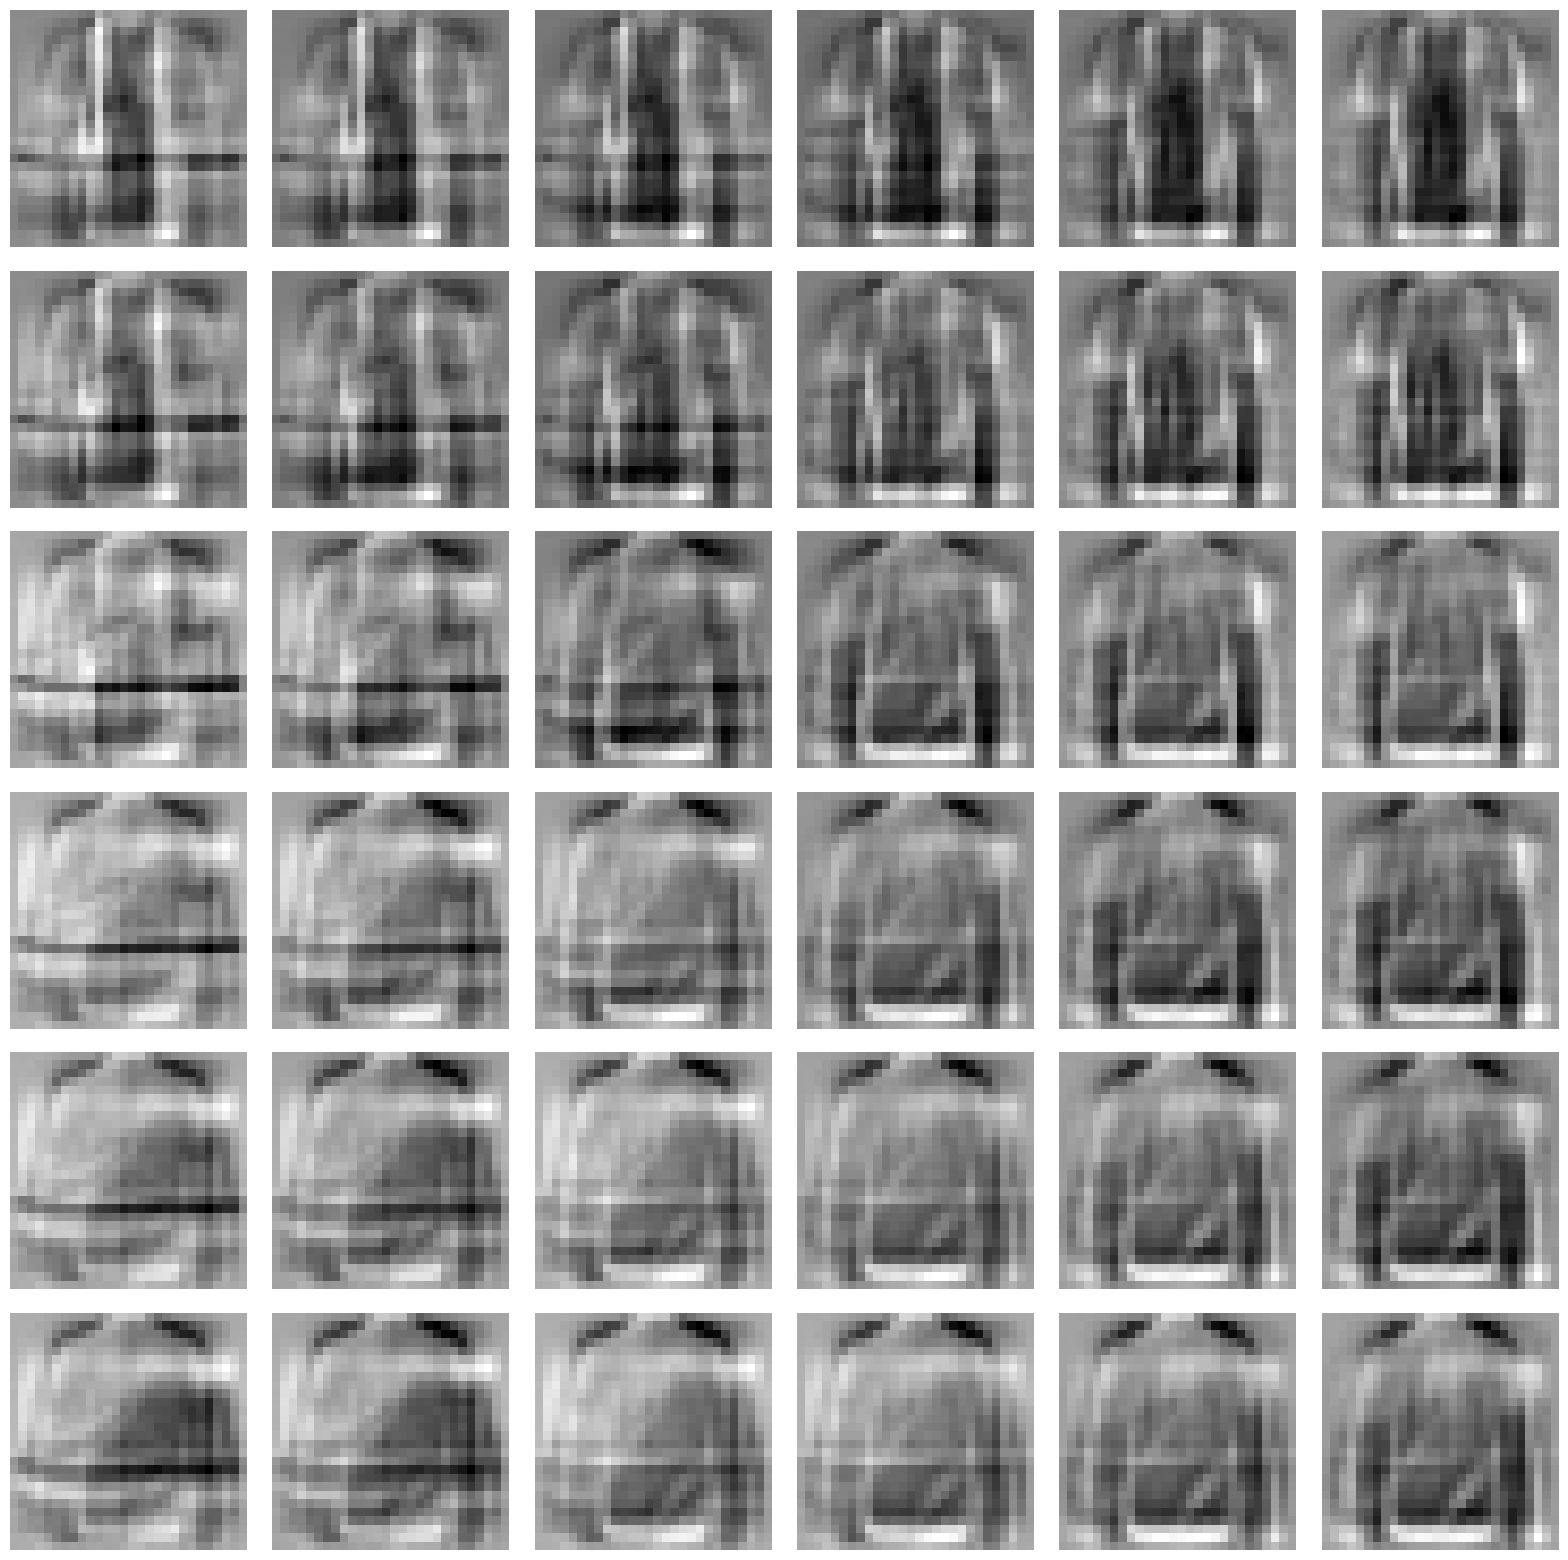

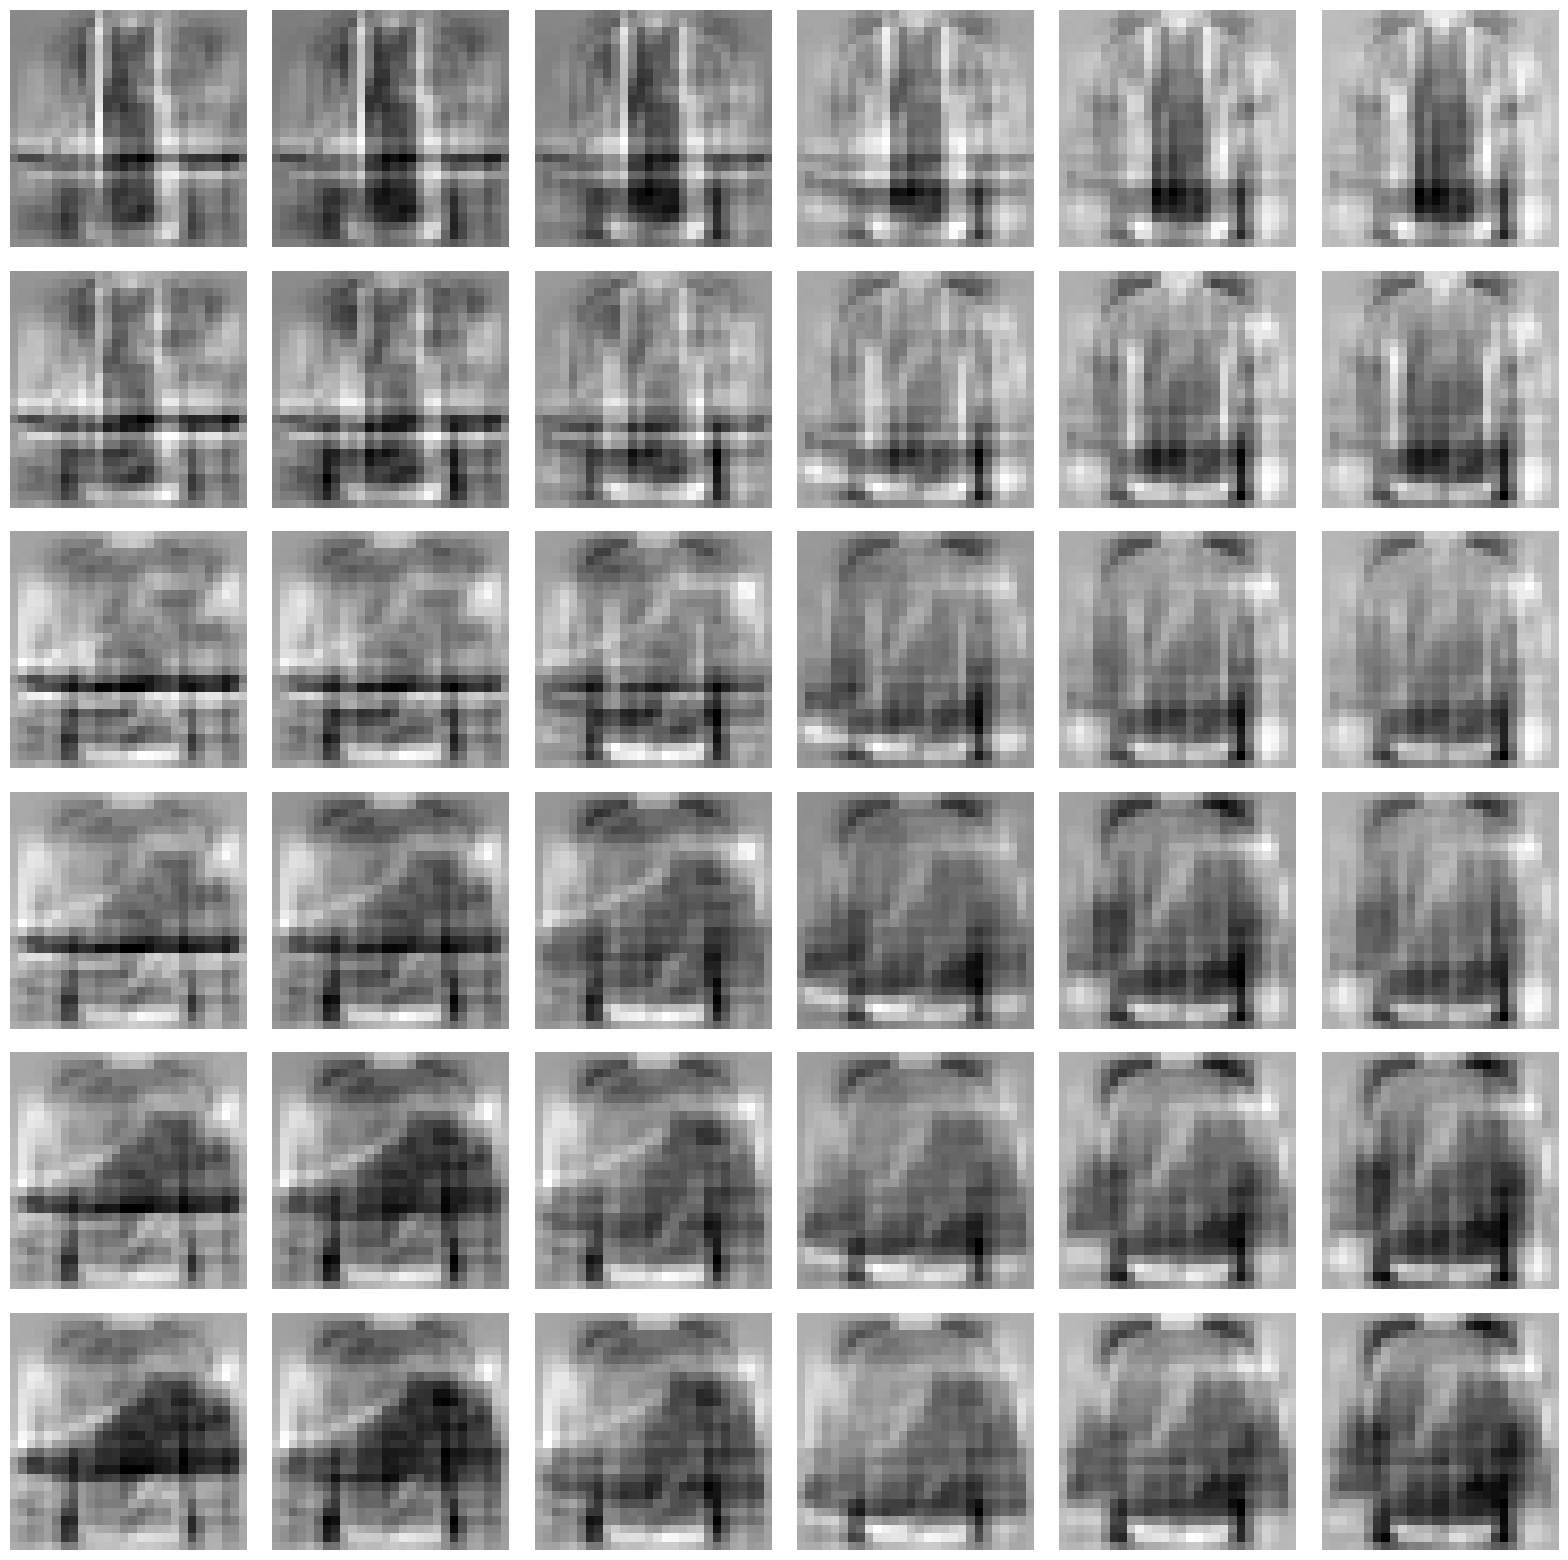

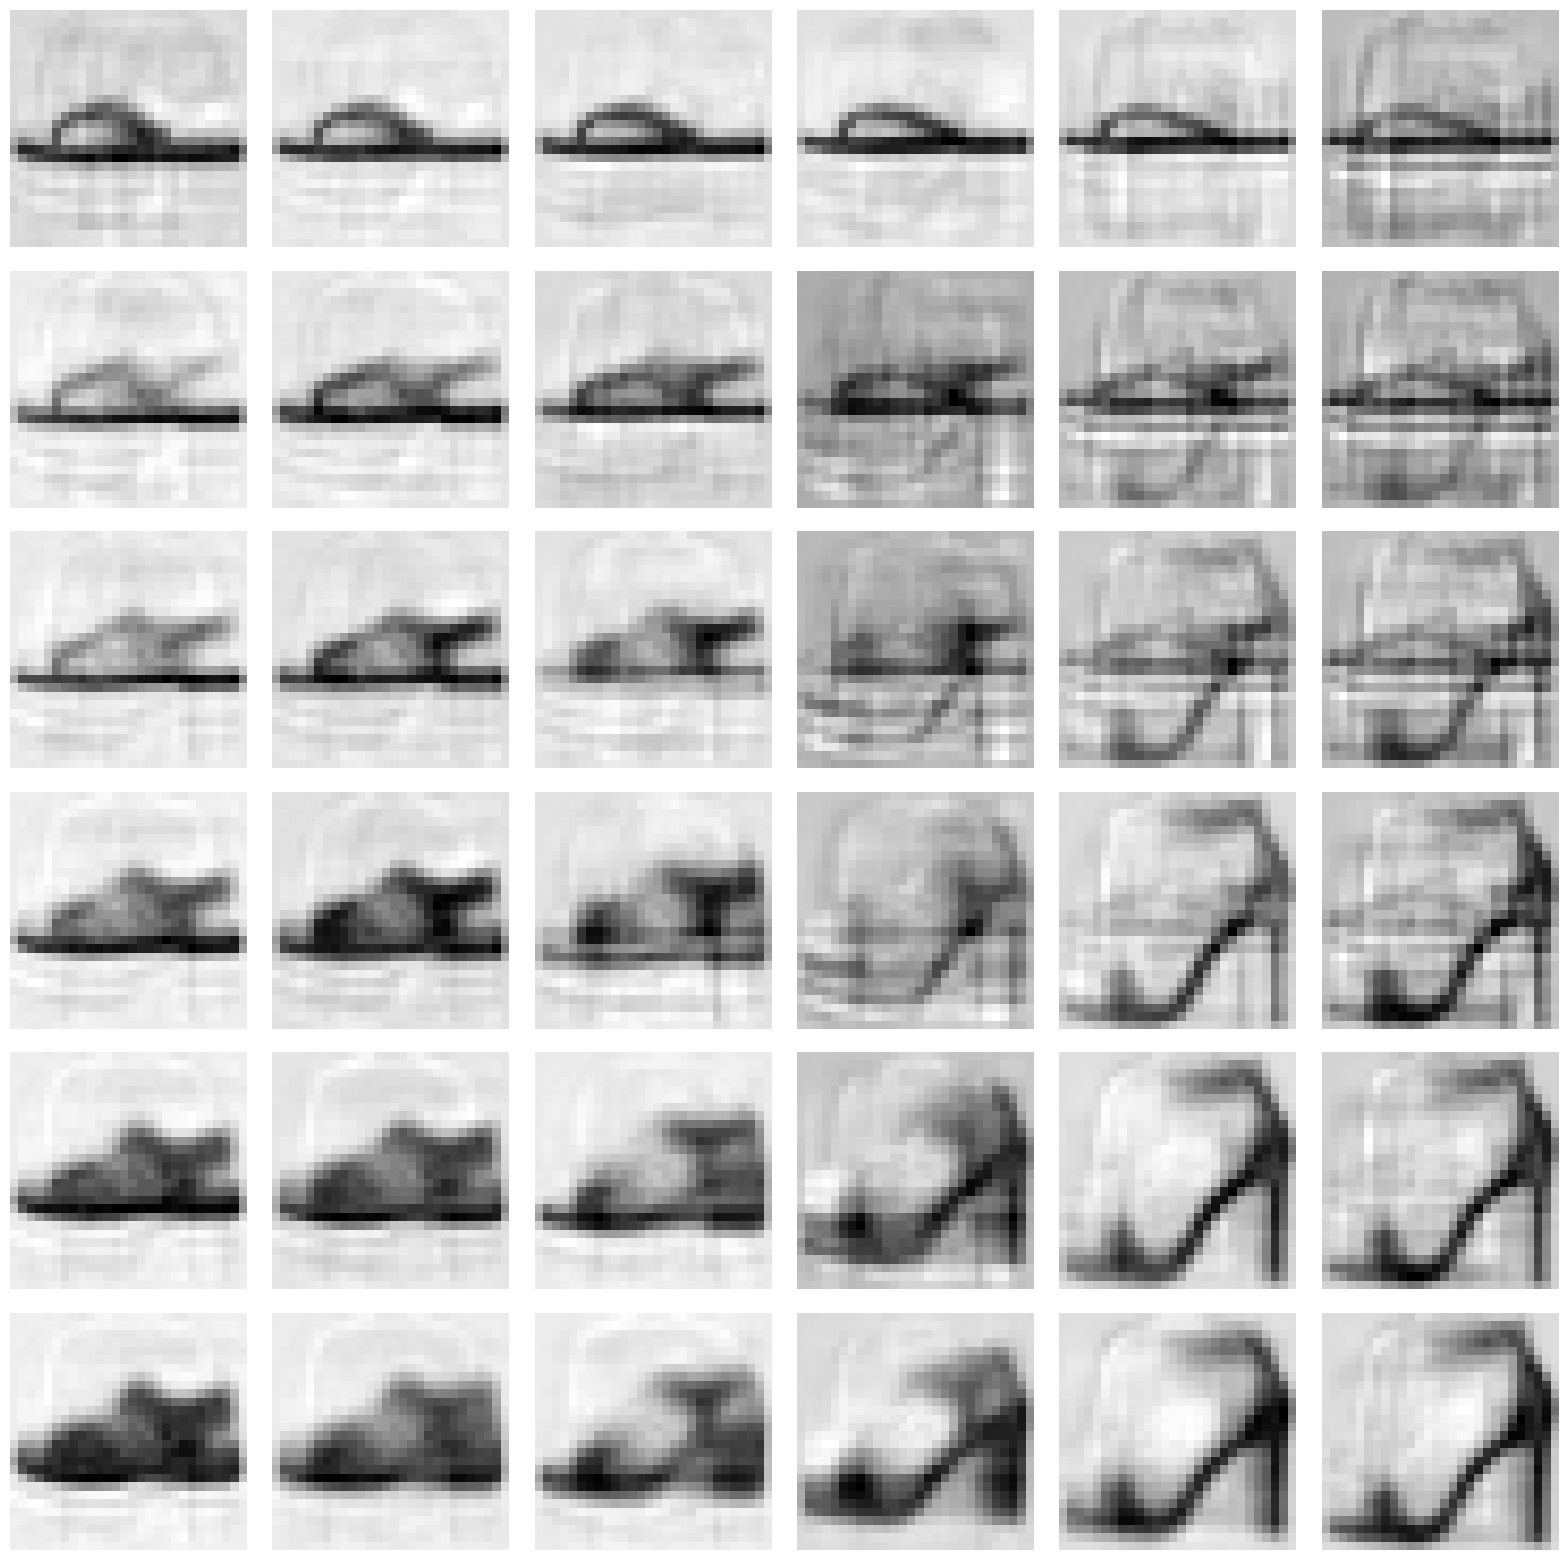

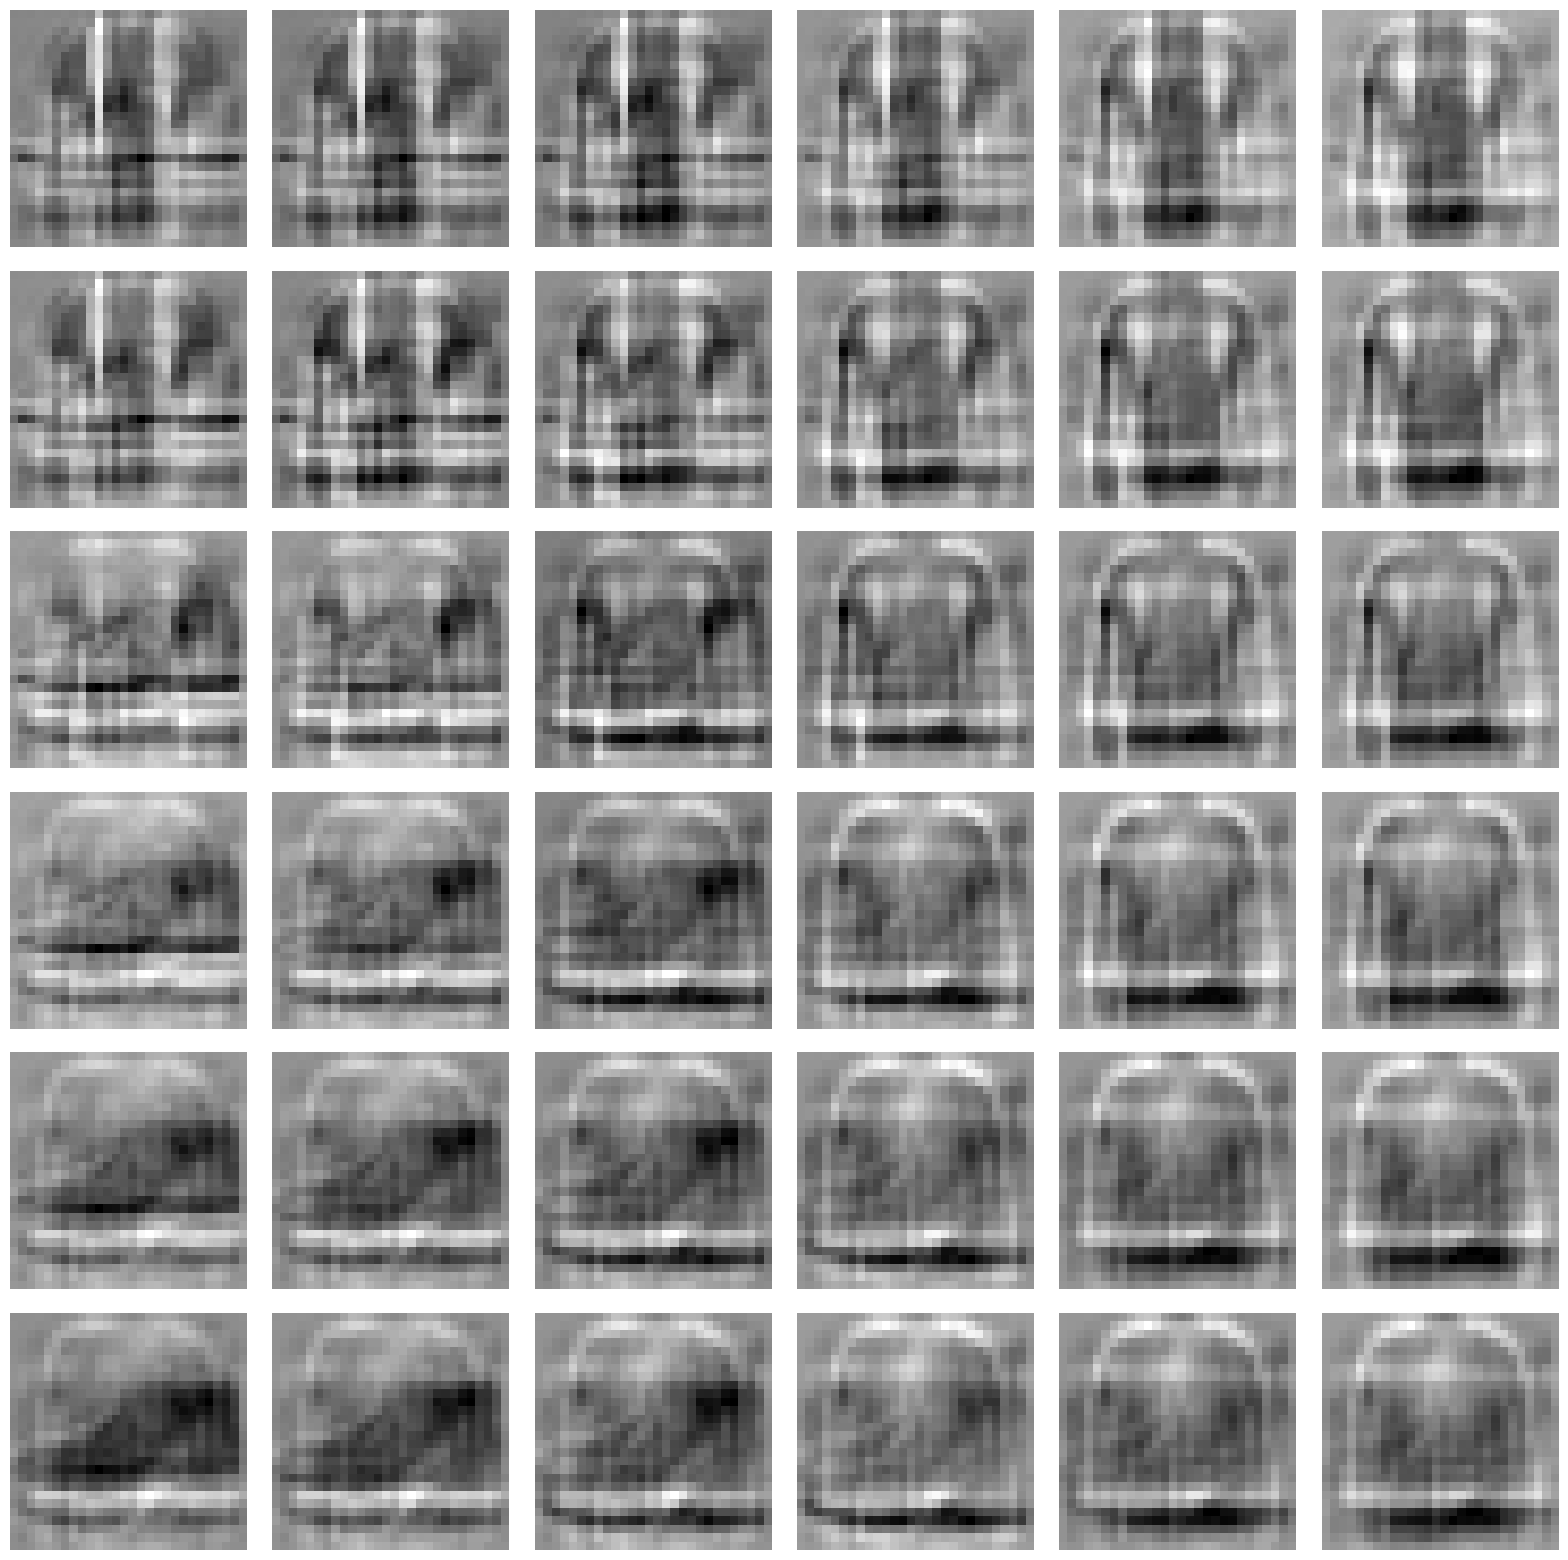

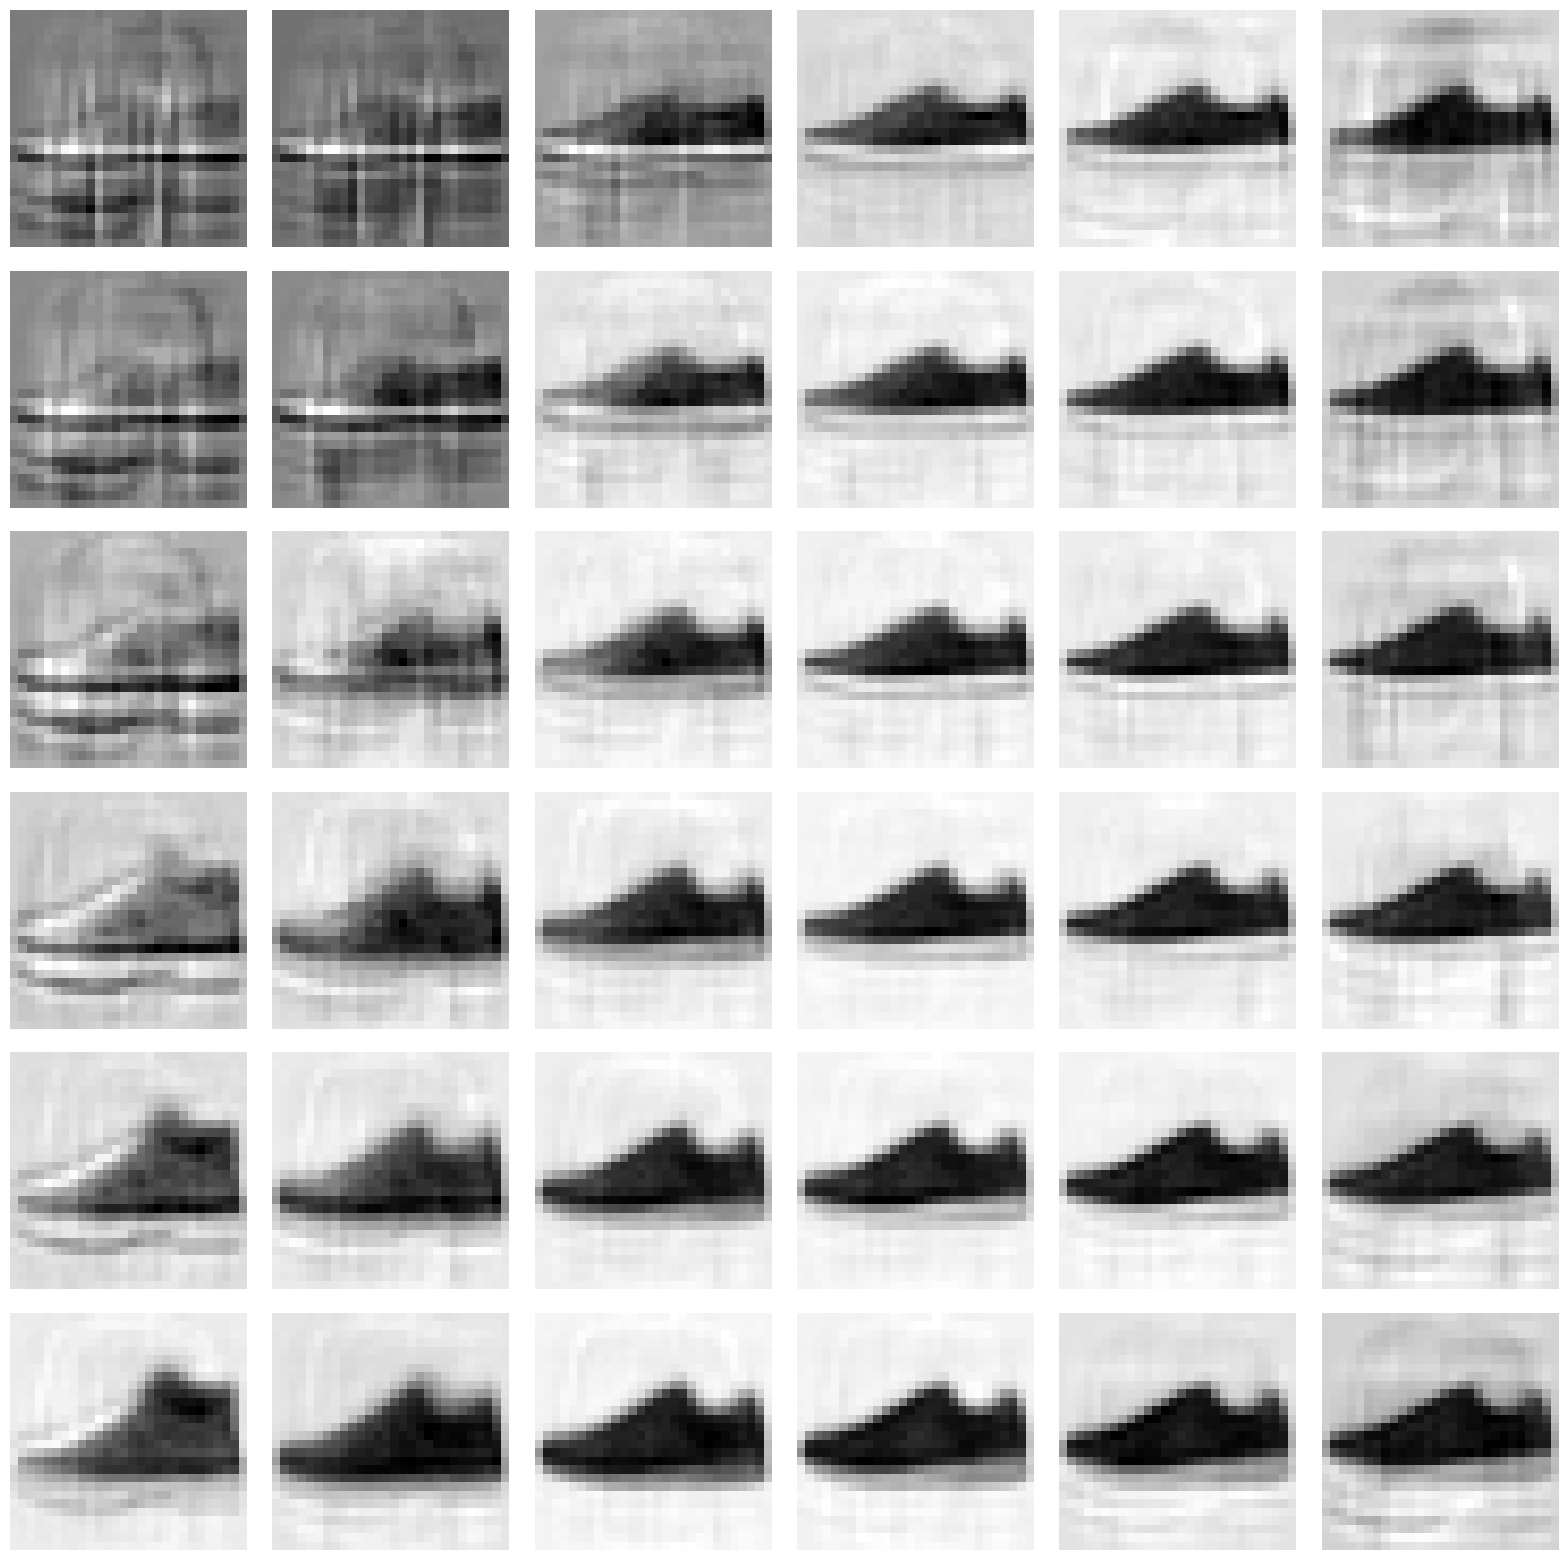

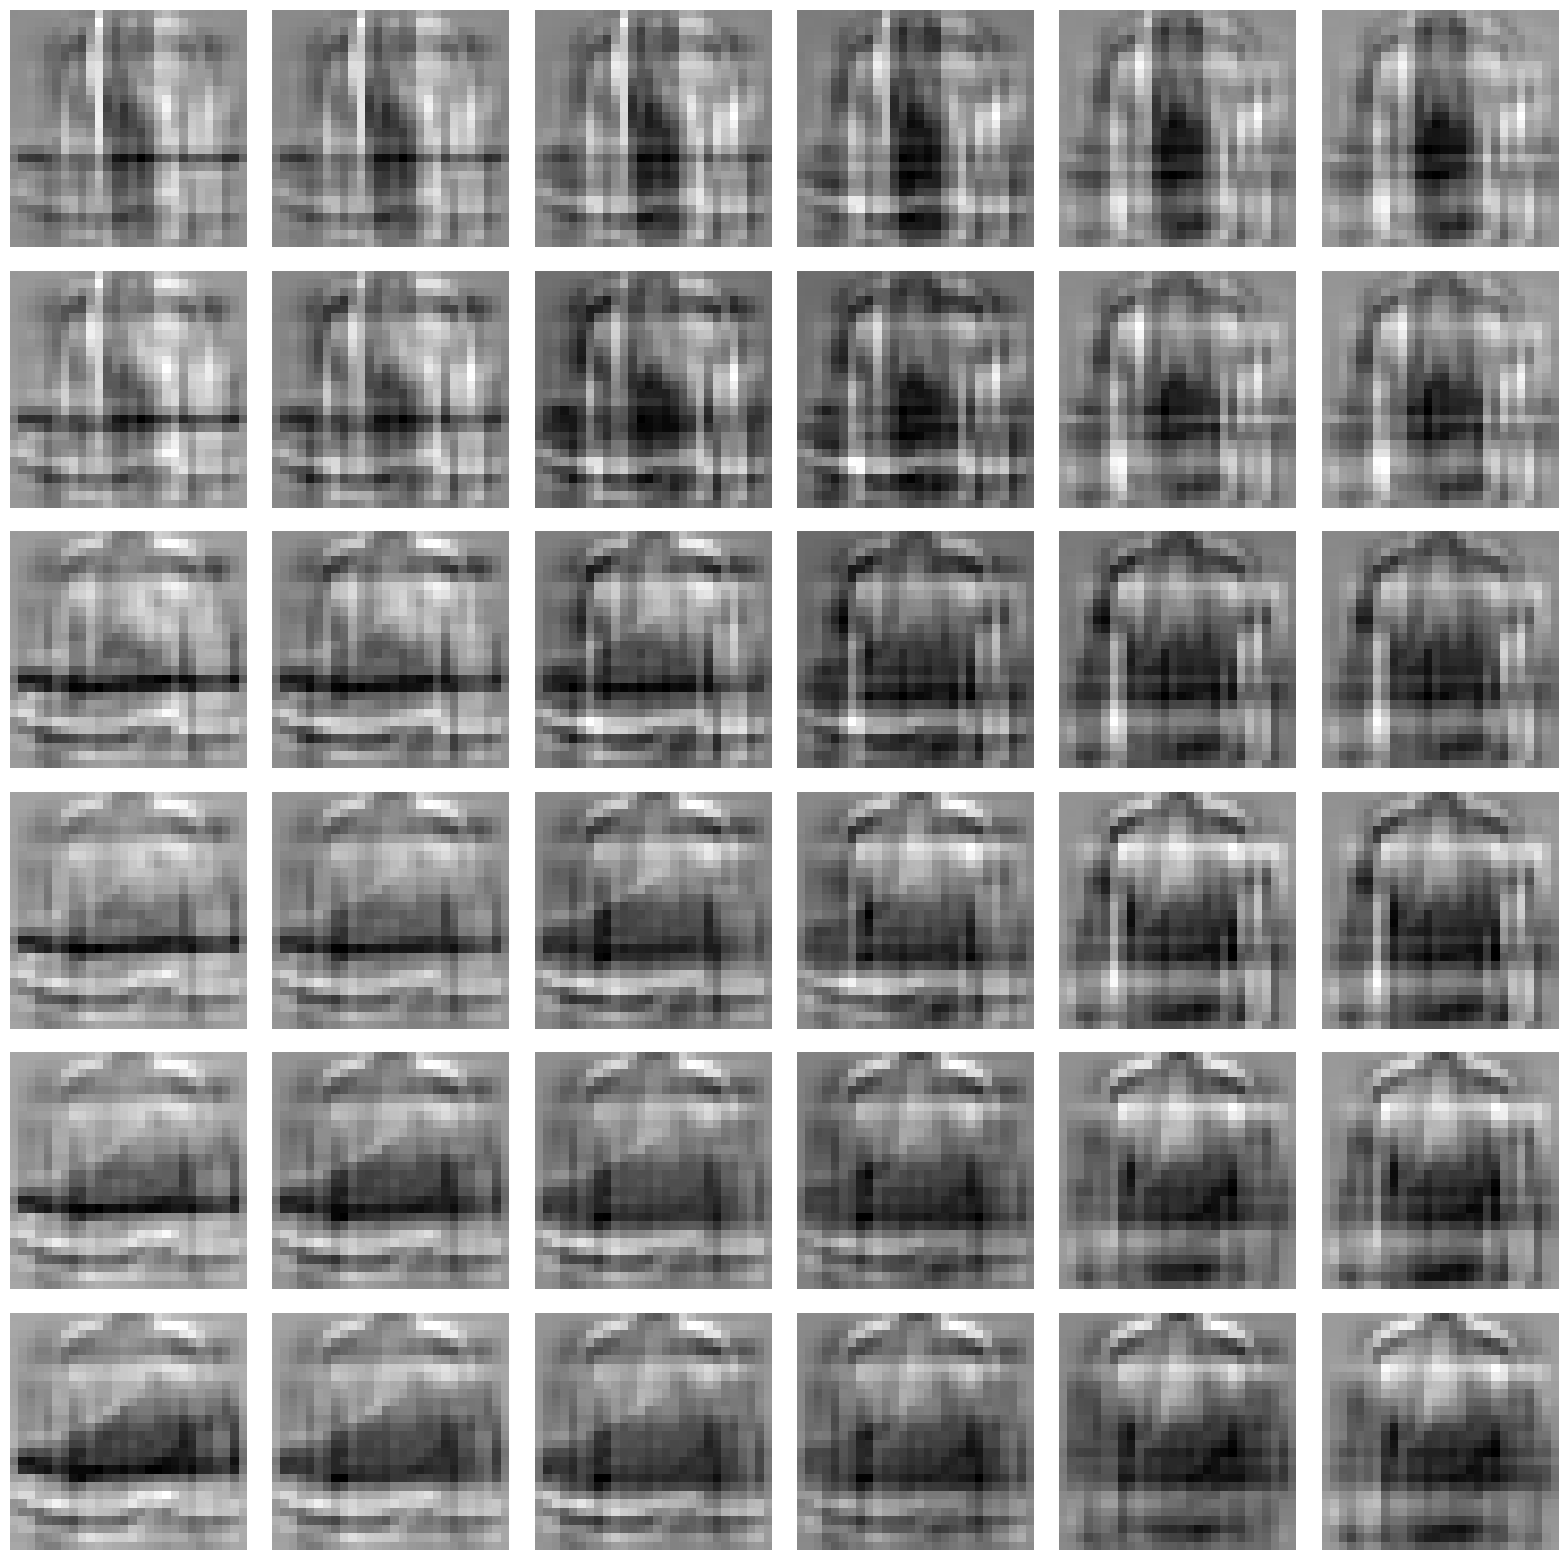

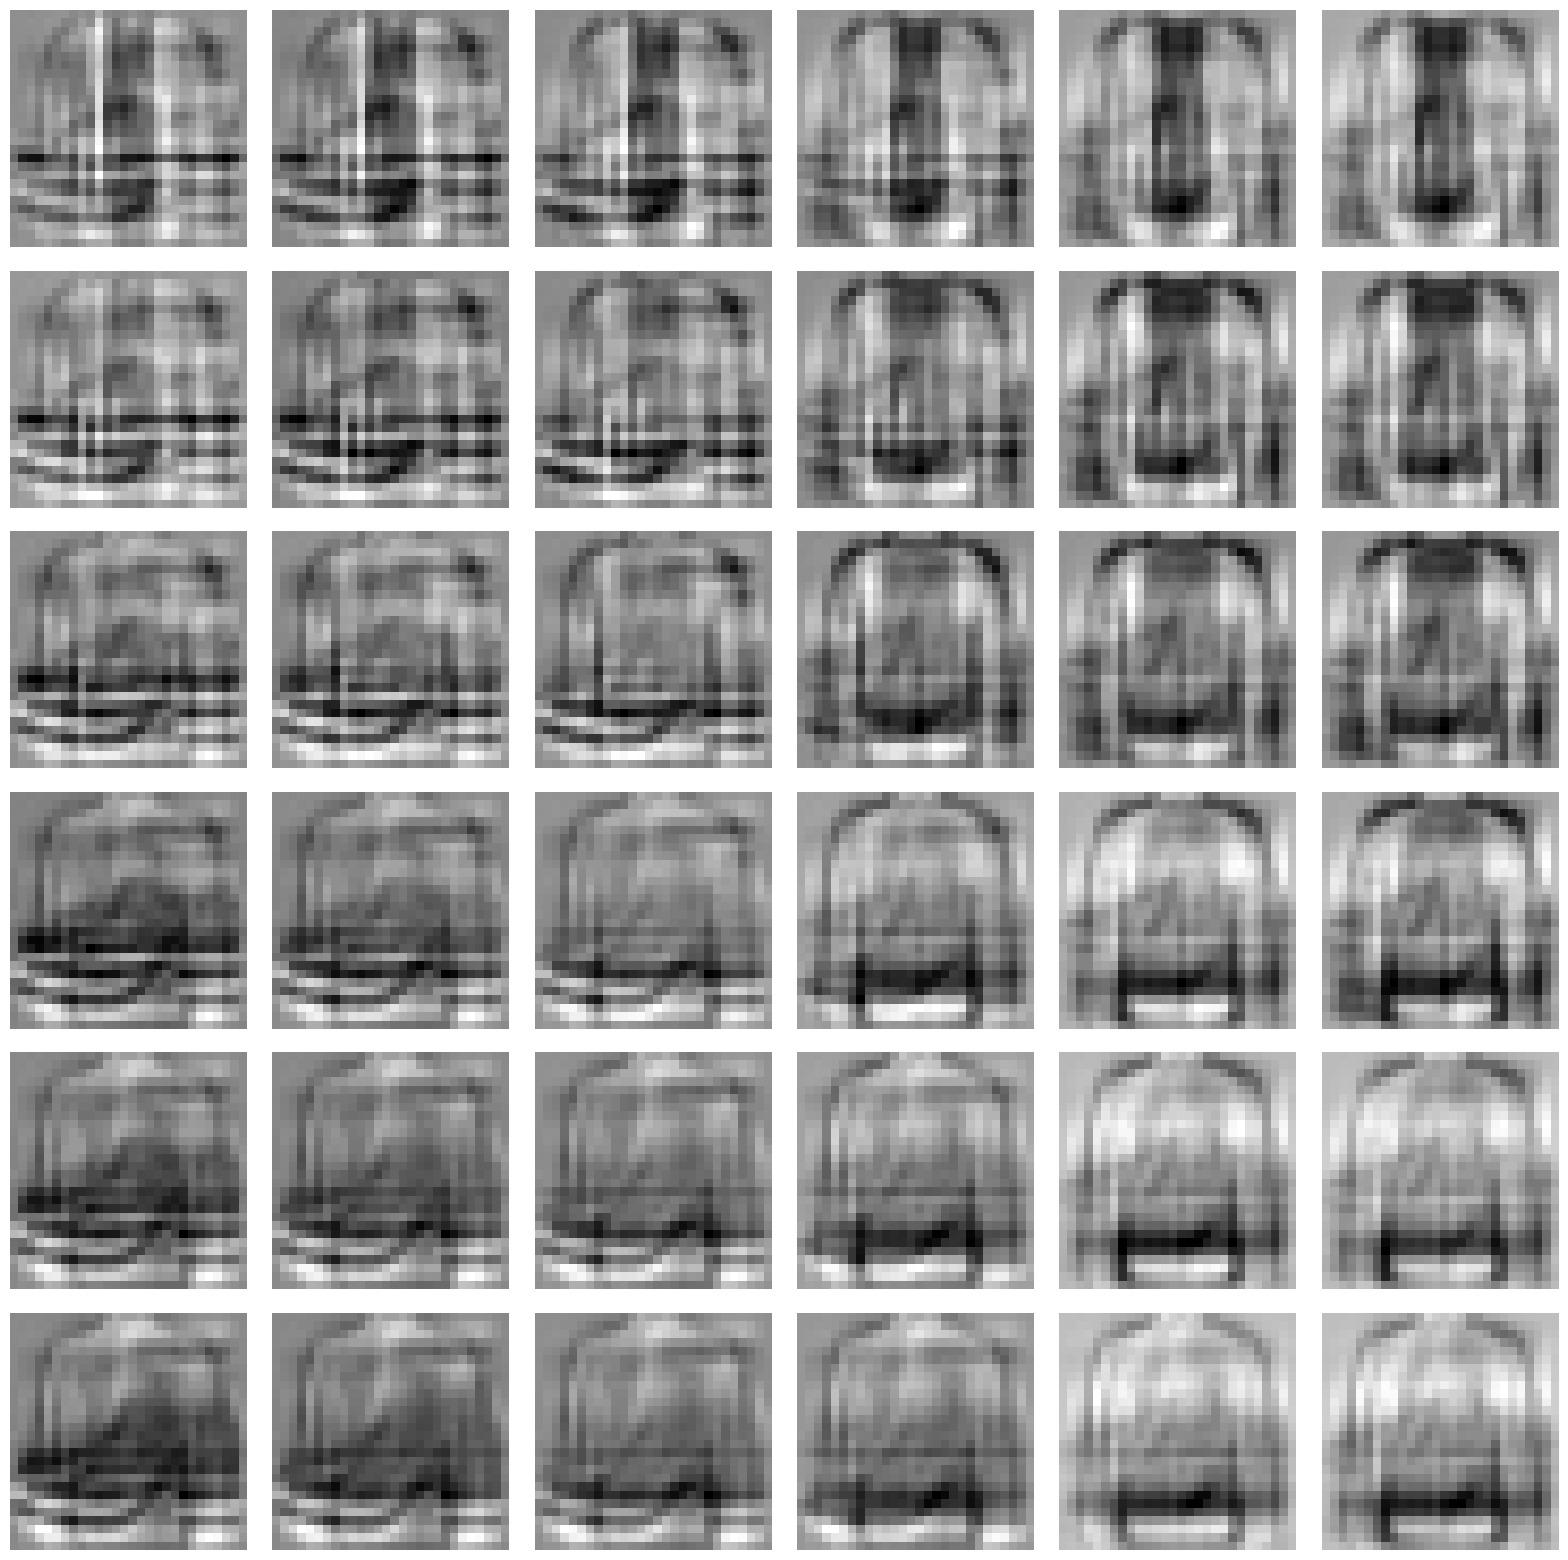

In [22]:
basis = np.identity(10)
steps = [2.0*x/10 for x in range(6)]
all = []
for v in basis:
    this_digit = []
    for c in combis(2, steps):
        this_digit.append(np.hstack([v, c]))
    res = decoder.predict(np.array(this_digit))
    show_digits(pd.DataFrame(res), len(steps), len(steps))
    all.extend(this_digit)
#res = decoder.predict(np.array(all))
#show_digits(pd.DataFrame(res), len(steps)**2, 10)

In [23]:
basis = decoder.predict(20*np.array(combis(n_latent, [0, 0.5, 1])))
show_digits(pd.DataFrame(basis), 9, basis.shape[0]//9)

16608/16608 [==============================] - 18s 1ms/step


KeyboardInterrupt: 